주제: 의료 인프라 분포에 기반한 의료 취약지 탐색 및 고령인구 의료접근성 향상을 위한 시각화 자료 구축
- 고령인구 의료접근성 향상을 위한 의료 인프라 분석 프레임워크 및 시각화 기반 의료취약지 탐색

1. API 불러오기
2. 병원데이터 전처리
3. 약국데이터 전처리
4. 인구데이터 전처리
5. Feature engineering
6. 모델링
7. 시각화

의료기관 크기도 확인할 것

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import os
import glob
import json
import re
import time
import requests
import xml.etree.ElementTree as ET
import random
import zipfile

# 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import branca.colormap as bcm  # folium 색상용 (이름 충돌 방지용으로 별칭)

# 지도 시각화
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip, GeoJsonPopup

# 공간 데이터 처리
from shapely.geometry import Point
import geopandas as gpd
from geopy.distance import great_circle
from scipy.spatial import cKDTree

# 클러스터링 및 분석
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    silhouette_score,
    silhouette_samples,
    roc_curve,
    auc
)

# 머신러닝 모델
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 통계 모델링
import statsmodels.api as sm

In [2]:
from matplotlib import font_manager, rc
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호가 깨지지 않도록 설정
plt.rcParams['axes.unicode_minus'] = False

## 1. API로 데이터 불러오기

In [ ]:
# 국립중앙의료원_전국 병·의원 찾기 서비스 인증키 불러오기
url_H = 'http://apis.data.go.kr/B552657/HsptlAsembySearchService/getHsptlMdcncFullDown'
api_H = 'SOecclsdpfuvGmi+5d/vkz3M5XiRZEpLLLAm6oeRb4lI6TJSEsmP4nOvH6DfEznSzCw8o3+Ktedgq18jQIGUmg=='

# 국립중앙의료원_전국 약국 정보 조회 서비스 인증키 불러오기
url_M = "http://apis.data.go.kr/B552657/ErmctInsttInfoInqireService/getParmacyFullDown"
api_M = 'SOecclsdpfuvGmi+5d/vkz3M5XiRZEpLLLAm6oeRb4lI6TJSEsmP4nOvH6DfEznSzCw8o3+Ktedgq18jQIGUmg=='

In [ ]:
# API에서 totalCount를 자동으로 가져와 전체 데이터를 수집
def fetch_all_data(api_url, api_key, num_of_rows=100, delay=0.05):  # 50ms 대기

    # totalCount 가져오기
    params = {
        'ServiceKey': api_key,
        'pageNo': '1',
        'numOfRows': '1'  # 한 개만 요청하여 totalCount 확인
    }
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        total_count_elem = root.find(".//totalCount")
        total_count = int(total_count_elem.text) if total_count_elem is not None else 0
    else:
        print(f"totalCount 가져오기 실패: 상태 코드 {response.status_code}")
        return []
    
    all_responses = []
    total_pages = (total_count // num_of_rows) + (1 if total_count % num_of_rows else 0)

    for page in range(1, total_pages + 1):
        params = {
            'ServiceKey': api_key,
            'pageNo': str(page),
            'numOfRows': str(num_of_rows)
        }
        response = requests.get(api_url, params=params)

        if response.status_code == 200:
            all_responses.append(response.content)
        else:
            print(f"페이지 {page} 요청 실패: 상태 코드 {response.status_code}")

        time.sleep(delay)  # 50ms 대기 (30TPS 제한 맞추기)

    return all_responses

# fetch_all_data()로 가져온 XML 데이터를 DataFrame으로 변환
def convert_xml_to_dataframe(xml_data_list):
    
    parsed_data = []

    for xml_data in xml_data_list:
        root = ET.fromstring(xml_data)

        for item in root.findall(".//item"):
            data = {child.tag: child.text for child in item}
            parsed_data.append(data)

    return pd.DataFrame(parsed_data) if parsed_data else None

In [ ]:
# fetach_all_data() 적용
response_H = fetch_all_data(url_H, api_H)
response_M = fetch_all_data(url_M, api_M)

# convert_xml_to_dataframe() 적용
df_H = convert_xml_to_dataframe(response_H)
df_M = convert_xml_to_dataframe(response_M)

# 엑셀 파일로 추출
df_H.to_excel("C:/Users/lglg/OneDrive/캡스톤/병원 풀데이터.xlsx", index=False)
df_M.to_excel("C:/Users/lglg/OneDrive/캡스톤/약국 풀데이터.xlsx", index=False)

## 2. 병원 데이터 전처리

In [3]:
# 병원 풀데이터 불러오기
hos = pd.read_excel("C:/Users/QQQ/Desktop/TeamMG/rawdata/병원 풀데이터.xlsx")

# 데이터프레임 형태로 변경
hos_df = pd.DataFrame(hos)
print(hos_df.shape)

(77707, 34)


In [4]:
# 병원 풀데이터에서 필요 없는 변수제거
drop_cols = ['dutyEmcls', 'dutyEmclsName', 'dutyEryn', 'dutyInf', 'dutyMapimg',
             'dutyTel1', 'dutyTime1c', 'dutyTime1s', 'dutyTime2c',
             'dutyTime2s', 'dutyTime3c', 'dutyTime3s', 'dutyTime4c', 'dutyTime4s',
             'dutyTime5c', 'dutyTime5s', 'hpid', 'postCdn1', 'postCdn2',
             'rnum', 'dutyTime6c', 'dutyTime6s', 'dutyTime7c', 'dutyTime7s',
             'dutyTime8c', 'dutyTime8s', 'dutyEtc', 'dutyTel3']

# 필요한 컬럼만 추려서 삭제
drop_cols_exist = [col for col in drop_cols if col in hos_df.columns]
hos_df = hos_df.drop(columns=drop_cols_exist)

# 각 변수 결측값 개수 확인
print(hos_df.isnull().sum())

dutyAddr      0
dutyDiv       0
dutyDivNam    0
dutyName      0
wgs84Lat      0
wgs84Lon      0
dtype: int64


In [5]:
# 'dutyAddr' 열의 이름을 'Jibun'으로 변경
hos_df.rename(columns={'dutyAddr': 'Jibun'}, inplace=True)

In [6]:
# 3차 병원 리스트: 23년 기준 45개
third_level_hospitals = [
    '강북삼성병원','고려대학교의과대학부속구로병원','연세대학교의과대학강남세브란스병원',
    '이화여자대학교의과대학부속목동병원','중앙대학교병원','학교법인가톨릭학원가톨릭대학교서울성모병원',
    '건국대학교병원','삼성서울병원','연세대학교의과대학세브란스병원','재단법인아산사회복지재단서울아산병원',
    '학교법인고려중앙학원고려대학교의과대학부속병원(안암병원)','한양대학교병원','경희대학교병원',
    '서울대학교병원','가톨릭대학교 인천성모병원','순천향대학교부속부천병원','의료법인 길의료재단 길병원',
    '인하대학교의과대학부속병원','고려대학교의과대학부속안산병원','분당서울대학교병원',
    '아주대학교병원','한림대학교성심병원','강릉아산병원','연세대학교원주세브란스기독병원',
    '충북대학교병원','단국대학교의과대학부속병원','충남대학교병원','원광대학교병원',
    '전북대학교병원','전남대학교병원','조선대학교병원','화순전남대학교병원','경북대학교병원',
    '계명대학교동산병원','대구가톨릭대학교병원','영남대학교병원','칠곡경북대학교병원',
    '동아대학교병원','부산대학교병원','양산부산대학교병원','인제대학교부산백병원',
    '학교법인울산공업학원울산대학교병원','경상국립대학교병원','학교법인성균관대학삼성창원병원','학교법인연세대학교의과대학세브란스병원'
]

# 1차·2차·기타 병원 분류 기준
hospital_level_map = {
    '의원': 1,
    '한의원': 1,
    '치과의원': 1,
    '보건소': 1,

    '병원': 2,
    '종합병원': 2,
    '요양병원': 2,
    '한방병원': 2,
    '치과병원': 2,

    '기타': 0,
    '기타(구급차)': 0
}

# 기본적으로 기관종별에 따라 구분
hos_df['의료기관구분'] = hos_df['dutyDivNam'].map(hospital_level_map)

# dutyName이 3차 병원 목록에 포함되면 무조건 '3차'로 재지정
hos_df.loc[hos_df['dutyName'].isin(third_level_hospitals), '의료기관구분'] = 3

# 결과 확인
print(hos_df['의료기관구분'].value_counts())
#0: 기타, 1: 1차, 2: 2차, 3: 3차

의료기관구분
1    73538
2     3961
0      164
3       44
Name: count, dtype: int64


In [7]:
missing_3rd = [name for name in third_level_hospitals if name not in hos_df['dutyName'].unique()]
print(f"누락된 3차 병원 수: {len(missing_3rd)}")
print("누락된 병원 목록:")
print(missing_3rd)

누락된 3차 병원 수: 1
누락된 병원 목록:
['학교법인연세대학교의과대학세브란스병원']


In [8]:
# 타겟 병원 키워드
target_keywords = ['의과대학세브란스']

# 필터링
filtered_df = hos_df[
    (hos_df['dutyName'].apply(lambda x: any(keyword in x for keyword in target_keywords)))]

# 결과 확인
print(filtered_df[['dutyName']])

              dutyName
31111  연세대학교의과대학세브란스병원


'학교법인연세대학교의과대학세브란스병원'은 데이터에 없기에 3차 병원에서 제외(45개 중 44개의 3차 기관만 사용)

### 시도 매핑

In [9]:
# hos_df 복사
hos_df_sido = hos_df.copy()

# 시도 매핑 딕셔너리
sido_mapping = {
    '서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시',
    '인천': '인천광역시', '광주': '광주광역시', '대전': '대전광역시',
    '울산': '울산광역시', '세종': '세종특별자치시', '경기': '경기도',
    '강원': '강원특별자치도', '충북': '충청북도', '충남': '충청남도',
    '전북': '전북특별자치도', '전남': '전라남도', '경북': '경상북도',
    '경남': '경상남도', '제주': '제주특별자치도', '전라북도': '전북특별자치도'
}

# 시도 추출 사용자 정의 함수 생성
def extract_sido(addr):
    if pd.isnull(addr):
        return None

    # 전체 시도명(풀네임)을 먼저 확인
    for full_sido in sido_mapping.values():
        if addr.startswith(full_sido):
            return full_sido

    # 시도 약어 매핑
    for short, full in sido_mapping.items():
        if addr.startswith(short):
            return full

    return None  # 매칭되지 않는 경우

# 위치 정의 함수 생성
def move_column_after(df, target_col, after_col):

    cols = df.columns.tolist()

    if target_col not in cols or after_col not in cols:
        raise ValueError(f"'{target_col}' 또는 '{after_col}' 컬럼이 존재하지 않습니다.")

    cols.remove(target_col)
    idx = cols.index(after_col)
    cols.insert(idx + 1, target_col)
    return df[cols]

# 'Jibun'에서 'Sido' 추출
hos_df_sido['Sido'] = hos_df_sido['Jibun'].apply(extract_sido)

# 'Sido'를 'Jibun' 다음으로 이동
hos_df_sido = move_column_after(hos_df_sido, 'Sido', 'Jibun')

# 각 변수 결측값 개수 확인
print(hos_df_sido.isnull().sum())

Jibun         0
Sido          0
dutyDiv       0
dutyDivNam    0
dutyName      0
wgs84Lat      0
wgs84Lon      0
의료기관구분        0
dtype: int64


In [10]:
sido_list = hos_df_sido['Sido'].dropna().unique().tolist()
print(sorted(sido_list))

['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [11]:
# 전국 법정동 파일 불러오기
all_df = pd.read_csv("C:/Users/QQQ/Desktop/TeamMG/rawdata/국토교통부_전국 법정동_20250415.csv",encoding='utf-8')
sigungu_list = all_df['시군구명'].dropna().unique().tolist()

# 시군구 추출 함수 정의
def extract_sigungu(addr, sigungu_list):
    if pd.isnull(addr):
        return None
    words = re.findall(r'\w+', addr)  # 단어 단위 추출
    for word in words:
        word = re.sub(r'[^\w가-힣]', '', word)  # 특수문자 제거
        if word in sigungu_list:
            return word
    return None

# hos_df_sido 복사
hos_df_sigungu = hos_df_sido.copy()

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
hos_df_sigungu['Sigungu'] = hos_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
hos_df_sigungu = move_column_after(hos_df_sigungu, 'Sigungu', 'Sido')

# 'Sigungu'가 결측이고 'Sido'가 '세종특별자치시'인 행만 선택하여 보완
mask = (hos_df_sigungu['Sigungu'].isnull()) & (hos_df_sigungu['Sido'] == '세종특별자치시')
hos_df_sigungu.loc[mask, 'Sigungu'] = '세종시'

# 결과 확인
print(hos_df_sigungu['Sigungu'].isnull().sum())

8


In [12]:
# 병원 데이터의 결측값 확인해보기
a = hos_df_sigungu[hos_df_sigungu['Sigungu'].isnull()]
print(a['Jibun'].head(10))

16777               경기도 금빛로 24-22 (굿닥터스빌딩 5층)
20152    부산광역시 신암로 34, 108동 202호 (범천경남아파트 상가)
21317                          부산광역시 중앙대로 786
44307            강원특별자치도  금강로 72, 3,5층 (흥만빌딩)
52374             경기도 하이파크3로 84, 503호 (신성프라자)
52542                 경기도 금빛로 27 (광장프라자 403호)
52978                 경기도 중앙로 46 (판타지아 빌딩 4층)
56893          대전광역시  진잠로 164 (지하1층, 지상2층~7층)
Name: Jibun, dtype: object


In [13]:
# 시군구가 결측인 행만 추출
missing_sigungu_df = hos_df_sigungu[hos_df_sigungu['Sigungu'].isnull()].copy()

# 카카오 Map에서 발급받은 REST API KEY
KAKAO_API_KEY = "9c32bb7527635581ea8a635372d899e1"

# 역지오코딩: 위경도 → 주소
def reverse_geocode(lat, lon, api_key):
    url = "https://dapi.kakao.com/v2/local/geo/coord2address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {"x": lon, "y": lat}
    try:
        res = requests.get(url, headers=headers, params=params)
        res.raise_for_status()
        result = res.json()
        return result['documents'][0]['address']['address_name']
    except:
        return None

# 위경도로부터 주소 추출
missing_sigungu_df['역지오코딩_주소'] = missing_sigungu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 역지오코딩된 주소로부터 시군구 재추출
missing_sigungu_df['시군구_보완'] = missing_sigungu_df['역지오코딩_주소'].apply(
    lambda x: extract_sigungu(x, sigungu_list)
)

# index 기준으로 원본에 시군구 보완 적용
hos_df_sigungu.loc[missing_sigungu_df.index, 'Sigungu'] = missing_sigungu_df['시군구_보완']

# 최종 결측값 확인
print(hos_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구 명이 같을때

In [14]:
# hos_df_sigungu 복사
hos_df_sigungu_1 = hos_df_sigungu.copy()

# 시도 축약 매핑 정의
sido_abbr = {
    '서울특별시': '서울', '부산광역시': '부산', '대구광역시': '대구',
    '인천광역시': '인천', '광주광역시': '광주', '대전광역시': '대전',
    '울산광역시': '울산', '세종특별자치시': '세종', '경기도': '경기',
    '강원특별자치도': '강원', '충청북도': '충북', '충청남도': '충남',
    '전북특별자치도': '전북', '전라남도': '전남', '경상북도': '경북',
    '경상남도': '경남', '제주특별자치도': '제주'
}

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = hos_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 시군구 보완 함수 정의
def revise_sigungu(row):
    if pd.isnull(row['Sido']) or pd.isnull(row['Sigungu']):
        return row['Sigungu']
    
    # 중복되는 시군구 이름만 보완
    if row['Sigungu'] in duplicated_sgg_names:
        short_sido = sido_abbr.get(row['Sido'], row['Sido'])
        return f"{short_sido} {row['Sigungu']}"
    else:
        return row['Sigungu']

# 적용
hos_df_sigungu_1['Sigungu'] = hos_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(hos_df_sigungu_1.isnull().sum())

Jibun         0
Sido          0
Sigungu       0
dutyDiv       0
dutyDivNam    0
dutyName      0
wgs84Lat      0
wgs84Lon      0
의료기관구분        0
dtype: int64


## 3. 약국 데이터 전처리

In [15]:
# 약국 풀데이터 불러오기
ph = pd.read_excel("C:/Users/QQQ/Desktop/TeamMG/rawdata/약국 풀데이터.xlsx")

# 데이터프레임 형태로 변경
ph_df = pd.DataFrame(ph)
print(ph_df.shape)

(24938, 29)


In [16]:
# 약국 풀데이터에서 필요 없는 변수제거
drop_cols = ['dutyEtc', 'dutyName', 'dutyFax', 'dutyInf', 'dutyMapimg','dutyTel1', 
             'dutyTime1c','dutyTime2c','dutyTime3c','dutyTime4c','dutyTime5c','dutyTime6c','dutyTime7c','dutyTime8c',
             'dutyTime1s','dutyTime2s','dutyTime3s','dutyTime4s','dutyTime5s','dutyTime6s','dutyTime7s','dutyTime8s',
             'rnum','hpid','postCdn1','postCdn2']

# 필요한 컬럼만 추려서 삭제
drop_cols_exist = [col for col in drop_cols if col in ph_df.columns]
ph_df = ph_df.drop(columns=drop_cols_exist)

# 각 변수 결측값 개수 확인
print(ph_df.isnull().sum())

dutyAddr    0
wgs84Lat    0
wgs84Lon    0
dtype: int64


In [17]:
# 'dutyAddr' 열의 이름을 'Jibun'으로 변경
ph_df.rename(columns={'dutyAddr': 'Jibun'}, inplace=True)

In [18]:
# 약국도 1차 기관에 속하기에 약국도 1차에 포함하기
ph_df['의료기관구분'] = 1

### 시도 매핑

In [19]:
# ph_df 복사
ph_df_sido = ph_df.copy()

# 열 순서 재배치: 'Jibun' 다음에 'Sido'가 오도록
ph_df_sido['Sido'] = ph_df_sido['Jibun'].apply(extract_sido)

# 'Sido'를 'Jibun' 다음으로 이동
ph_df_sido = move_column_after(ph_df_sido, 'Sido', 'Jibun')

# 각 변수 결측값 개수 확인
print(ph_df_sido.isnull().sum())

Jibun       0
Sido        0
wgs84Lat    0
wgs84Lon    0
의료기관구분      0
dtype: int64


In [20]:
# 시도 리스트 확인
sido_list = ph_df_sido['Sido'].dropna().unique().tolist()
print(sorted(sido_list))

['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [21]:
# ph_df_sido 복사
ph_df_sigungu = ph_df_sido.copy()

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
ph_df_sigungu['Sigungu'] = ph_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
ph_df_sigungu = move_column_after(ph_df_sigungu, 'Sigungu', 'Sido')

# 'Sigungu'가 결측이고 'Sido'가 '세종특별자치시'인 행만 선택하여 보완
mask = (ph_df_sigungu['Sigungu'].isnull()) & (ph_df_sigungu['Sido'] == '세종특별자치시')
ph_df_sigungu.loc[mask, 'Sigungu'] = '세종시'

# 결과 확인
print(ph_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구 명이 같을 때

In [22]:
# ph_df_sigungu 복사
ph_df_sigungu_1 = ph_df_sigungu.copy()

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = ph_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 적용
ph_df_sigungu_1['Sigungu'] = ph_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(ph_df_sigungu_1.isnull().sum())

Jibun       0
Sido        0
Sigungu     0
wgs84Lat    0
wgs84Lon    0
의료기관구분      0
dtype: int64


## 4. 인구 데이터 전처리

In [23]:
# 인구 데이터 불러오기
pl = pd.read_csv("C:/Users/QQQ/Desktop/TeamMG/rawdata/행정안전부_지역별(법정동) 성별 연령별 주민등록 인구수_20250331.csv", encoding='cp949')

# 데이터프레임 형태로 변경
pl_df = pd.DataFrame(pl)
print(pl_df.shape)

(18710, 234)


In [24]:
# 인구 데이터에서 필요없는 변수제거
drop_cols = ['기준연월', '리명', '0세남자', '1세남자', '2세남자', '3세남자', '4세남자', '5세남자', '6세남자', '7세남자', '8세남자', '9세남자', '10세남자', '11세남자', '12세남자', '13세남자', '14세남자', '15세남자', '16세남자', '17세남자', '18세남자', '19세남자', '20세남자', '21세남자', '22세남자', '23세남자', '24세남자', '25세남자', '26세남자', '27세남자', '28세남자', '29세남자', '30세남자', '31세남자', '32세남자', '33세남자', '34세남자', '35세남자', '36세남자', '37세남자', '38세남자', '39세남자', '40세남자', '41세남자', '42세남자', '43세남자', '44세남자', '45세남자', '46세남자', '47세남자', '48세남자', '49세남자', '50세남자', '51세남자', '52세남자', '53세남자', '54세남자', '55세남자', '56세남자', '57세남자', '58세남자', '59세남자', '60세남자', '61세남자', '62세남자', '63세남자', '64세남자', '65세남자', '66세남자', '67세남자', '68세남자', '69세남자', '70세남자', '71세남자', '72세남자', '73세남자', '74세남자', '75세남자', '76세남자', '77세남자', '78세남자', '79세남자', '80세남자', '81세남자', '82세남자', '83세남자', '84세남자', '85세남자', '86세남자', '87세남자', '88세남자', '89세남자', '90세남자', '91세남자', '92세남자', '93세남자', '94세남자', '95세남자', '96세남자', '97세남자', '98세남자', '99세남자', '100세남자', '101세남자', '102세남자', '103세남자', '104세남자', '105세남자', '106세남자', '107세남자', '108세남자', '109세남자', '110세이상 남자', '0세여자', '1세여자', '2세여자', '3세여자', '4세여자', '5세여자', '6세여자', '7세여자', '8세여자', '9세여자', '10세여자', '11세여자', '12세여자', '13세여자', '14세여자', '15세여자', '16세여자', '17세여자', '18세여자', '19세여자', '20세여자', '21세여자', '22세여자', '23세여자', '24세여자', '25세여자', '26세여자', '27세여자', '28세여자', '29세여자', '30세여자', '31세여자', '32세여자', '33세여자', '34세여자', '35세여자', '36세여자', '37세여자', '38세여자', '39세여자', '40세여자', '41세여자', '42세여자', '43세여자', '44세여자', '45세여자', '46세여자', '47세여자', '48세여자', '49세여자', '50세여자', '51세여자', '52세여자', '53세여자', '54세여자', '55세여자', '56세여자', '57세여자', '58세여자', '59세여자', '60세여자', '61세여자', '62세여자', '63세여자', '64세여자', '65세여자', '66세여자', '67세여자', '68세여자', '69세여자', '70세여자', '71세여자', '72세여자', '73세여자', '74세여자', '75세여자', '76세여자', '77세여자', '78세여자', '79세여자', '80세여자', '81세여자', '82세여자', '83세여자', '84세여자', '85세여자', '86세여자', '87세여자', '88세여자', '89세여자', '90세여자', '91세여자', '92세여자', '93세여자', '94세여자', '95세여자', '96세여자', '97세여자', '98세여자', '99세여자', '100세여자', '101세여자', '102세여자', '103세여자', '104세여자', '105세여자', '106세여자', '107세여자', '108세여자', '109세여자', '110세이상 여자']
pl_df.drop(columns=drop_cols, inplace=True)

# 각 변수 결측값 개수 확인
print(pl_df.isnull().sum())

법정동코드    0
시도명      0
시군구명     8
읍면동명     0
계        0
남자       0
여자       0
고령 인구    0
고령 남자    0
고령 여자    0
dtype: int64


In [25]:
# 시군구명 결측값 확인하기
a = pl_df[pl_df['시군구명'].isnull()]
print(a['시도명'].head(10))

1893    세종특별시
1894    세종특별시
1896    세종특별시
1900    세종특별시
1901    세종특별시
1909    세종특별시
1910    세종특별시
1914    세종특별시
Name: 시도명, dtype: object


In [26]:
# 세종특별자치시인 행의 시군구명을 시도명으로 통일
pl_df.loc[pl_df['시도명'] == '세종특별시', '시군구명'] = '세종시'

# 시군구명 변수 결측값 개수 확인
print(pl_df['시군구명'].isnull().sum())

0


In [27]:
# pl_df 복사
pl_df_jibun = pl_df.copy()

# 시도명, 시군구명, 읍면동명을 혼합한 Jibun 변수 생성
pl_df_jibun['Jibun'] = (
    pl_df_jibun['시도명']+ ' ' +
    pl_df_jibun['시군구명']+ ' ' +
    pl_df_jibun['읍면동명']
).str.strip()

# 'Jibun'을 '법정도코드' 다음으로 이동
pl_df_jibun = move_column_after(pl_df_jibun, 'Jibun', '법정동코드')

# 각 변수 결측값 개수 확인
print(pl_df_jibun.isnull().sum())

법정동코드    0
Jibun    0
시도명      0
시군구명     0
읍면동명     0
계        0
남자       0
여자       0
고령 인구    0
고령 남자    0
고령 여자    0
dtype: int64


### 시도 매핑

In [28]:
# 시도명을 표준화하는 함수 정의
def standardize_sido(sido_raw):
    if pd.isnull(sido_raw):
        return None  # 결측값 처리

    sido_raw = str(sido_raw).strip()  # 공백 제거 및 문자열화

    # 정확히 일치하는 경우 우선 처리
    if sido_raw in sido_mapping.values():
        return sido_raw

    # 축약어로 시작하는 경우 변환
    for short, full in sido_mapping.items():
        if sido_raw.startswith(short):
            return full

    # 변환 불가능한 경우 원본 유지
    return sido_raw

# 표준화 함수 적용
pl_df_jibun['시도명'] = pl_df_jibun['시도명'].apply(standardize_sido)

# 컬럼명 변경
pl_df_jibun.rename(columns={'시도명': 'Sido'}, inplace=True)

# 결과 확인
print("표준화 후 결측값 수:", pl_df_jibun['Sido'].isnull().sum())
print("시도명 목록:", sorted(pl_df_jibun['Sido'].unique()))

표준화 후 결측값 수: 0
시도명 목록: ['강원특별자치도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전북특별자치도', '제주특별자치도', '충청남도', '충청북도']


### 시군구 매핑

In [29]:
# pl_df_jibun 복사
pl_df_sigungu = pl_df_jibun.copy()

# '시군구명' 열의 이름을 'Sigungu'으로 변경
pl_df_sigungu.rename(columns={'시군구명': 'Sigungu'}, inplace=True)

# 데이터프레임에서 'Jibun' 열을 기준으로 시군구 추출
pl_df_sigungu['Sigungu'] = pl_df_sigungu['Jibun'].apply(lambda x: extract_sigungu(x, sigungu_list))

# 'Sigungu'를 'Sido' 다음으로 이동
pl_df_sigungu = move_column_after(pl_df_sigungu, 'Sigungu', 'Sido')

# 결과 확인
print(pl_df_sigungu['Sigungu'].isnull().sum())

0


#### 시도는 다르지만 시군구는 다를 때

In [30]:
# pl_df_sigungu 복사
pl_df_sigungu_1 = pl_df_sigungu.copy()

# 시군구별 중복 확인 (시군구만 기준으로)
duplicate_sgg = pl_df_sigungu_1.groupby('Sigungu')['Sido'].nunique()
duplicated_sgg_names = duplicate_sgg[duplicate_sgg > 1].index.tolist()

# 적용
pl_df_sigungu_1['Sigungu'] = pl_df_sigungu_1.apply(revise_sigungu, axis=1)

# 결과 확인
print(pl_df_sigungu_1.isnull().sum())

법정동코드      0
Jibun      0
Sido       0
Sigungu    0
읍면동명       0
계          0
남자         0
여자         0
고령 인구      0
고령 남자      0
고령 여자      0
dtype: int64


### 표준화 처리 확인하기

In [31]:
# 각 데이터 복사
hos_df = hos_df_sigungu_1.copy()
ph_df = ph_df_sigungu_1.copy()
pl_df = pl_df_sigungu_1.copy()

# 시도 표준화가 잘 되었는지 확인하기
print(set(hos_df['Sido']) == set(ph_df['Sido']) == set(pl_df['Sido']))

# 시군구 표준화가 잘 되었는지 확인하기
print(set(hos_df['Sigungu']) == set(ph_df['Sigungu']) == set(pl_df['Sigungu']))

True
False


#### 시군구 표준화 확인 및 처리

In [32]:
# pl_df vs hos_df의 시군구 비교
pl_set = set(pl_df['Sigungu'])
hos_set = set(hos_df['Sigungu'])

print("공통 (pl & hos):", len(pl_set & hos_set))
print("pl에만 있는 시군구:", pl_set - hos_set)
print("hos에만 있는 시군구:", hos_set - pl_set)

공통 (pl & hos): 229
pl에만 있는 시군구: set()
hos에만 있는 시군구: {'인천 남구'}


In [33]:
# 인천의 남구는 미추홀구로 변경됨. 더 확실한 검정을 위해 역지오 코딩 활용
# 인천 남구만 필터링
namgu_df = hos_df[
    (hos_df['Sigungu'] == '인천 남구') &
    (hos_df['wgs84Lat'].notnull()) &
    (hos_df['wgs84Lon'].notnull())
].copy()

namgu_df['역지오코딩_주소'] = namgu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 시군구명 보완 함수 정의
def extract_sigungu_from_address(addr, sigungu_list):
    if pd.isnull(addr):
        return None
    for sigungu in sigungu_list:
        if sigungu in addr:
            return sigungu
    return None

# 역지오코딩된 주소로부터 시군구 보완
namgu_df['시군구_보완'] = namgu_df['역지오코딩_주소'].apply(lambda x: extract_sigungu_from_address(x, sigungu_list))

# 원본 hos_df에 시군구 보완 업데이트
hos_df.loc[namgu_df.index, 'Sigungu'] = namgu_df['시군구_보완']

# 결과 확인
print(hos_df['Sigungu'].value_counts().get('인천 남구', 0))

# 변경 전후 테이블 확인
print(namgu_df[['역지오코딩_주소', '시군구_보완']].drop_duplicates())

0
                역지오코딩_주소 시군구_보완
44835  인천 미추홀구 주안동 989-1   미추홀구


In [34]:
# pl_df vs ph_df의 시군구 비교
ph_set = set(ph_df['Sigungu'])

print("공통 (pl & ph):", len(pl_set & ph_set))
print("pl에만 있는 시군구:", pl_set - ph_set)
print("ph에만 있는 시군구:", ph_set - pl_set)

공통 (pl & ph): 229
pl에만 있는 시군구: set()
ph에만 있는 시군구: {'인천 남구'}


In [35]:
# 인천 남구만 필터링
namgu_df = ph_df[
    (ph_df['Sigungu'] == '인천 남구') &
    (ph_df['wgs84Lat'].notnull()) &
    (ph_df['wgs84Lon'].notnull())
].copy()

namgu_df['역지오코딩_주소'] = namgu_df.apply(
    lambda row: reverse_geocode(row['wgs84Lat'], row['wgs84Lon'], KAKAO_API_KEY),
    axis=1
)

# 역지오코딩된 주소로부터 시군구 보완
namgu_df['시군구_보완'] = namgu_df['역지오코딩_주소'].apply(lambda x: extract_sigungu_from_address(x, sigungu_list))

# 원본 ph_df에 시군구 보완 업데이트
ph_df.loc[namgu_df.index, 'Sigungu'] = namgu_df['시군구_보완']

# 결과 확인
print(ph_df['Sigungu'].value_counts().get('인천 남구', 0))

# 변경 전후 테이블 확인
print(namgu_df[['역지오코딩_주소', '시군구_보완']].drop_duplicates())

0
                 역지오코딩_주소 시군구_보완
17038  인천 미추홀구 주안동 473-20   미추홀구


In [36]:
# hos_df vs ph_df의 시군구 비교
print("공통 (hos & ph):", len(hos_set & ph_set))
print("hos에만 있는 시군구:", hos_set - ph_set)
print("ph에만 있는 시군구:", ph_set - hos_set)

공통 (hos & ph): 230
hos에만 있는 시군구: set()
ph에만 있는 시군구: set()


In [37]:
# 시군구 표준화 확인하기
print(set(hos_df['Sigungu']) == set(ph_df['Sigungu']) == set(pl_df['Sigungu']))

True


## 5. Feature engineering

In [38]:
# 각 데이터프레임 복사
hos_df_f = hos_df.copy() # 병원 데이터
ph_df_f = ph_df.copy() # 약국 데이터
pl_df_f = pl_df.copy() # 인구 데이터

# 각 데이터프레임의 형태 확인
print(hos_df_f.shape)
print(ph_df_f.shape)
print(pl_df_f.shape)

(77707, 9)
(24938, 6)
(18710, 11)


In [39]:
# dutyDiv와 dutyDivNam 간 매핑 확인 (중복 제거)
duty_mapping = hos_df_f[['dutyDiv', 'dutyDivNam']].drop_duplicates().sort_values(by='dutyDiv')

# 결과 출력
print(duty_mapping)

     dutyDiv dutyDivNam
1003       A       종합병원
17         B         병원
2          C         의원
101        D       요양병원
27         E       한방병원
0          G        한의원
141        I         기타
991        M       치과병원
5          N       치과의원
122        R        보건소
437        W    기타(구급차)


In [40]:
# 'dutyDivNam' 컬럼의 모든 범주와 각 범주별 개수
# dutyDiv와 dutyDivNam의 고유 조합 추출
unique_mapping = hos_df_f[['dutyDiv', 'dutyDivNam']].drop_duplicates()

# dutyDiv 오름름차순 정렬
unique_mapping_sorted = unique_mapping.sort_values(by='dutyDiv', ascending=True)

# dutyDivNam별 개수 계산
count_by_dutyDivNam = hos_df_f['dutyDivNam'].value_counts()

# dutyDiv 오름차순 순서에 맞게 개수 재정렬
count_by_dutyDivNam_sorted = count_by_dutyDivNam.reindex(unique_mapping_sorted['dutyDivNam'])

# 결과 출력
print(count_by_dutyDivNam_sorted)

dutyDivNam
종합병원         375
병원          1441
의원         36418
요양병원        1357
한방병원         586
한의원        14631
기타           103
치과병원         246
치과의원       19013
보건소         3476
기타(구급차)       61
Name: count, dtype: int64


### 5-1) 의료 인프라 관련 Feature

#### 5-1-1) 시도에 대한 의료기관 통계

##### 1) 인구 100만명 대비 종합병원수

In [41]:
# pl_df_f의 '계' 열의 이름을 'Count'로 변경
pl_df_f.rename(columns={'계': 'pl_count'}, inplace=True)

# 시도별 인구 데이터 준비
pop_by_sido = pl_df_f.groupby('Sido')['pl_count'].sum().reset_index()

# ph_df_f에 'dutyDivNam' 생성 (사용자 정의 함수를 사용하기 위함)
ph_df_f['dutyDivNam'] = '약국'

# 의료기관 통계 및 시각화를 위한 사용자 정의 함수
def plot_facility_per_population(
    facility_df,               # 병원/약국/시설 데이터프레임
    pop_df,                    # 인구 데이터프레임 (Sido, pl_count 필요)
    facility_name,             # 필터링할 시설 이름 (예: '한의원', '요양병원')
    unit=100000,               # 인구 기준 단위 (예: 100000 → 10만명당)
    palette='YlOrRd_r'           # 색상 팔레트
):
    # 시설 필터링
    filtered = facility_df[facility_df['dutyDivNam'] == facility_name]

    # 시도별 시설 수 집계
    count_by_sido = filtered.groupby('Sido').size().reset_index(name='facility_count')

    # 병합: 시도별 인구 수와 시설 수
    merged = pd.merge(count_by_sido, pop_df, on='Sido')

    # 인구 단위당 시설 수 계산
    col_name = f'{facility_name}_per_{unit//10000}만명'
    merged[col_name] = (merged['facility_count'] / merged['pl_count'] * unit).round(2)

    # 정렬
    merged = merged.sort_values(by=col_name, ascending=False)

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)

    plt.title(f'시도별 인구 {unit//10000}만명당 {facility_name} 수', fontsize=16)
    plt.ylabel(f'{facility_name} 수 (인구 {unit//10000}만명당)', fontsize=12)
    plt.xlabel('시도', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    for i, val in enumerate(merged[col_name]):
        plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


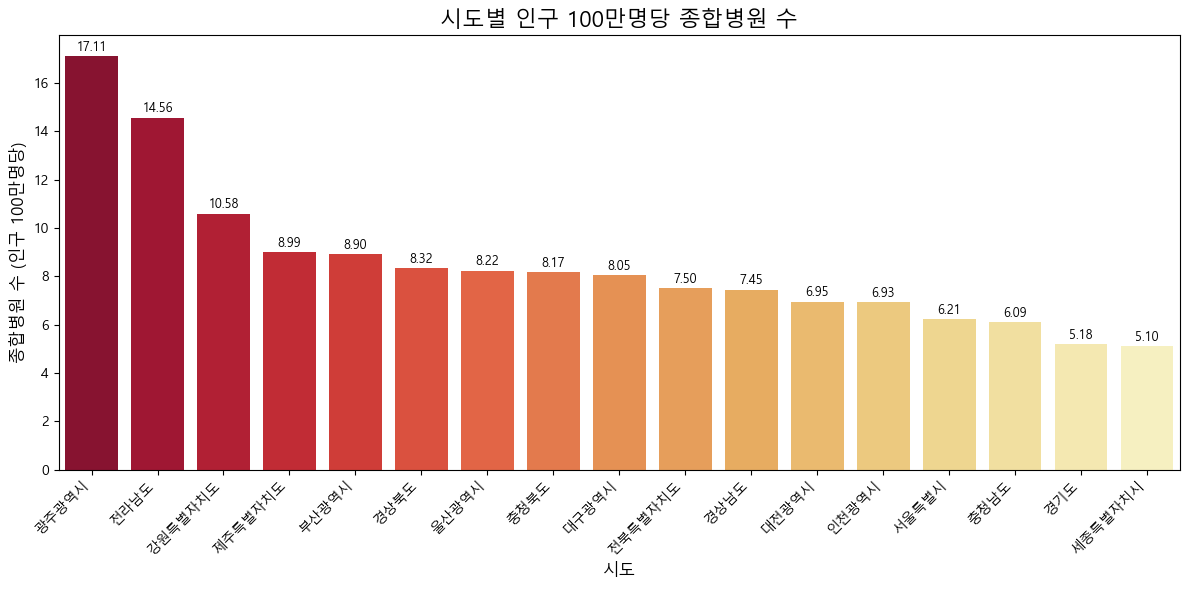

In [42]:
# 인구 100만 명당 종합병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='종합병원',
    unit=1000000
)

##### 2) 인구 100만명 대비 병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


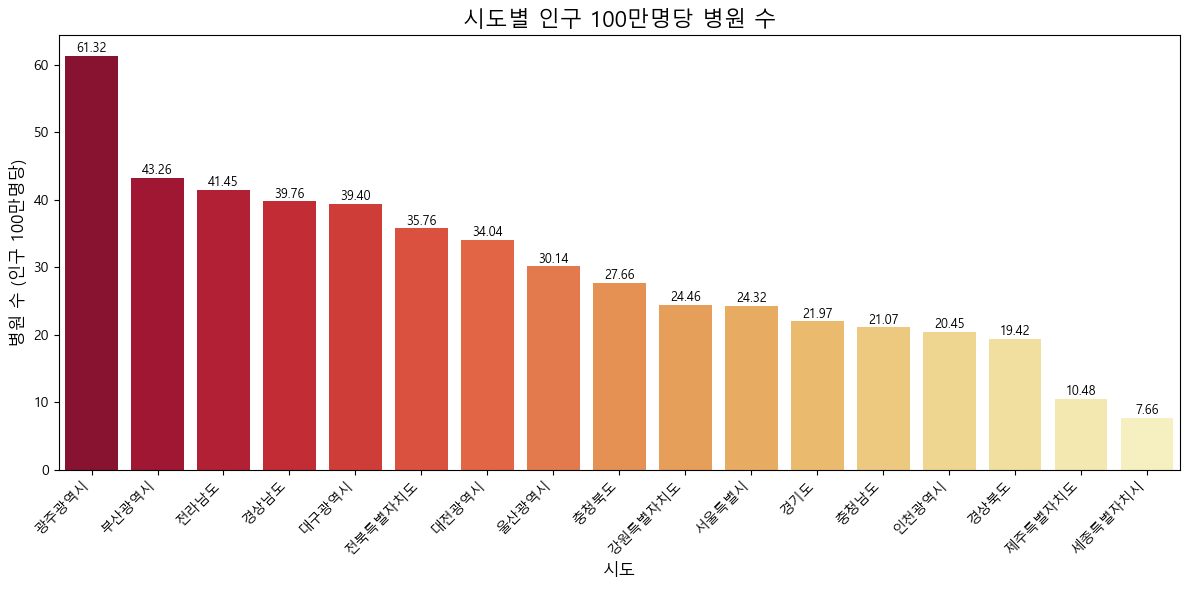

In [43]:
# 인구 100만 명당 병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='병원',
    unit=1000000
)

##### 3) 인구 1만명 대비 의원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


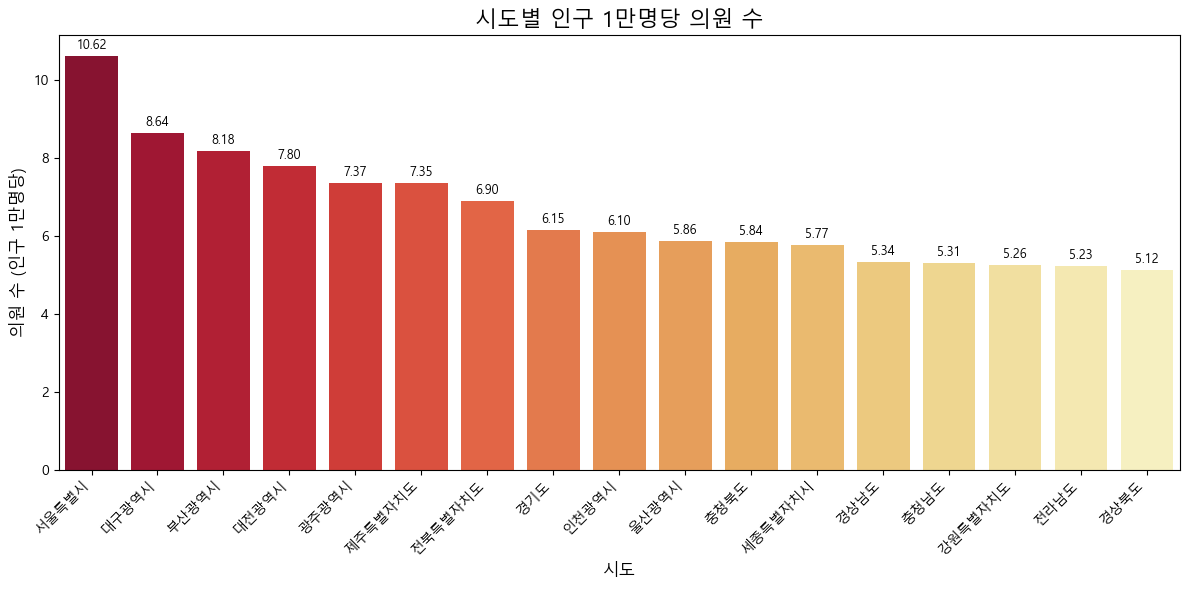

In [44]:
# 인구 1만 명당 의원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='의원',
    unit=10000
)

##### 4) 인구 100만명 대비 치과병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


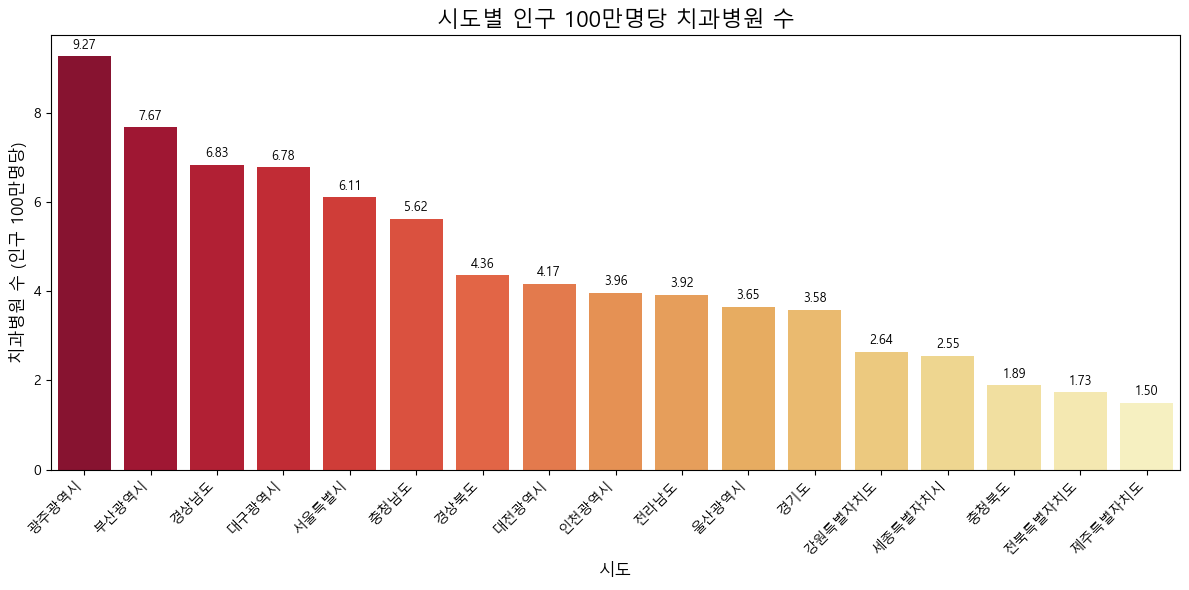

In [45]:
# 인구 100만 명당 치과병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='치과병원',
    unit=1000000
)

##### 5) 인구 10만명 대비 치과의원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


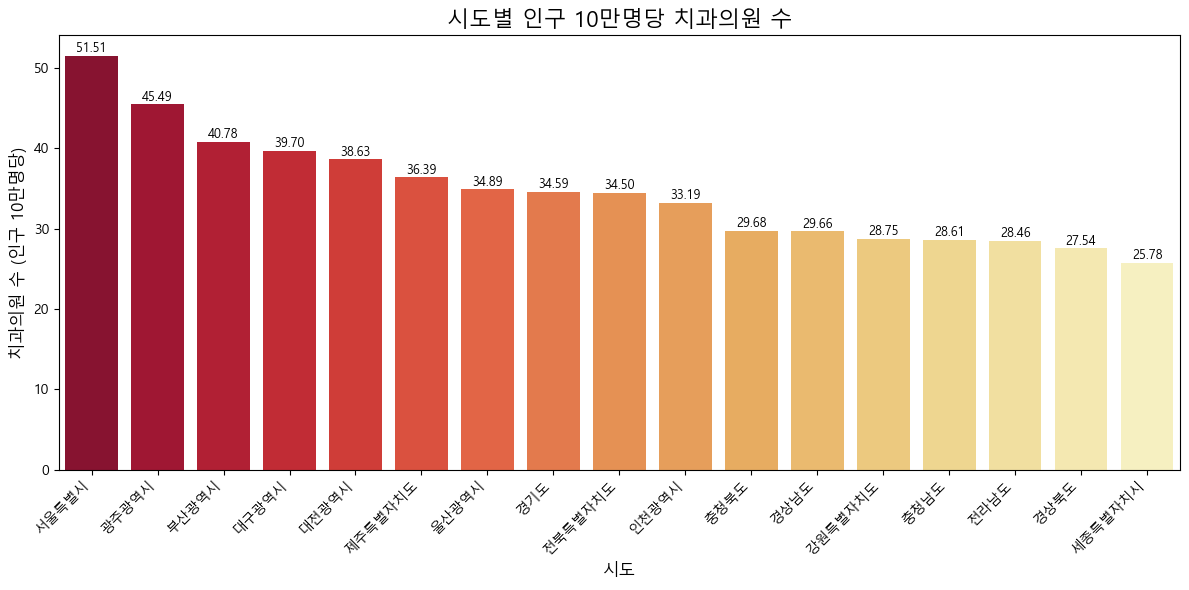

In [46]:
# 인구 10만 명당 치과의원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='치과의원',
    unit=100000
)

##### 6) 인구 100만명 대비 요양병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


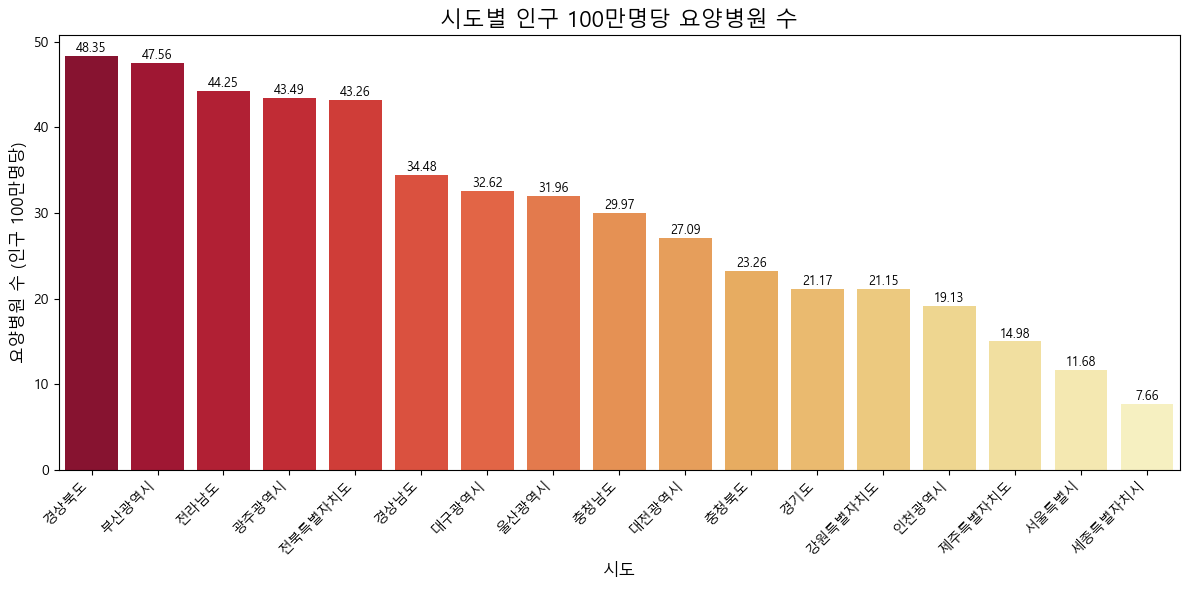

In [47]:
# 인구 100만명당 요양병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='요양병원',
    unit=1000000
)

##### 7) 인구 100만명 대비 한방병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


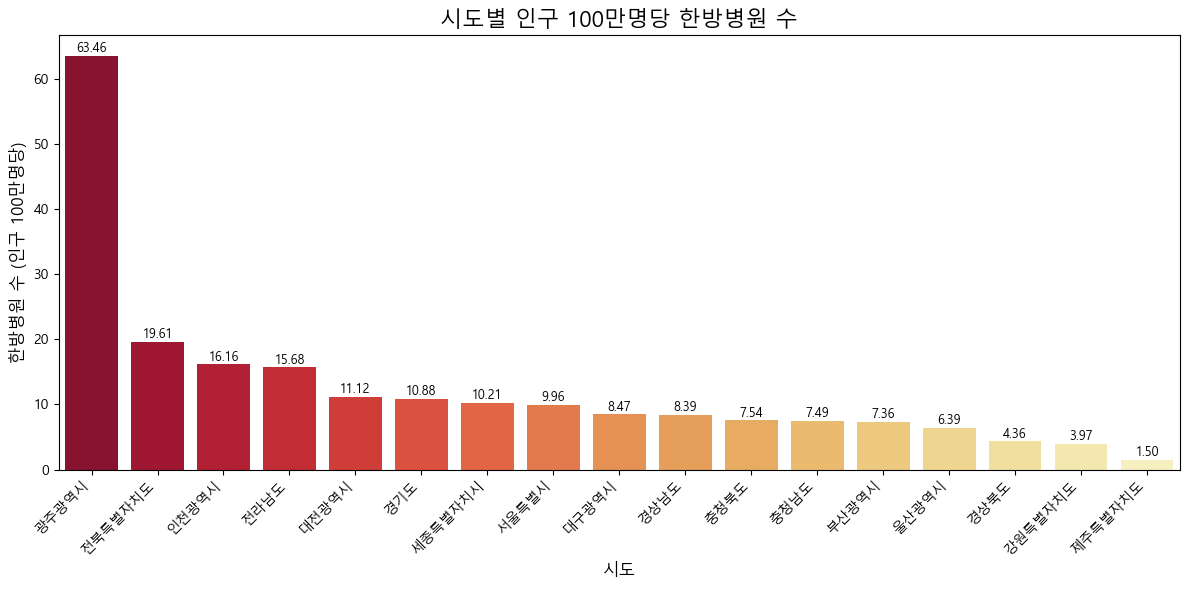

In [48]:
# 인구 100만명당 한방병원수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='한방병원',
    unit=1000000
)

##### 8) 인구 10만명 대비 한의원 수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


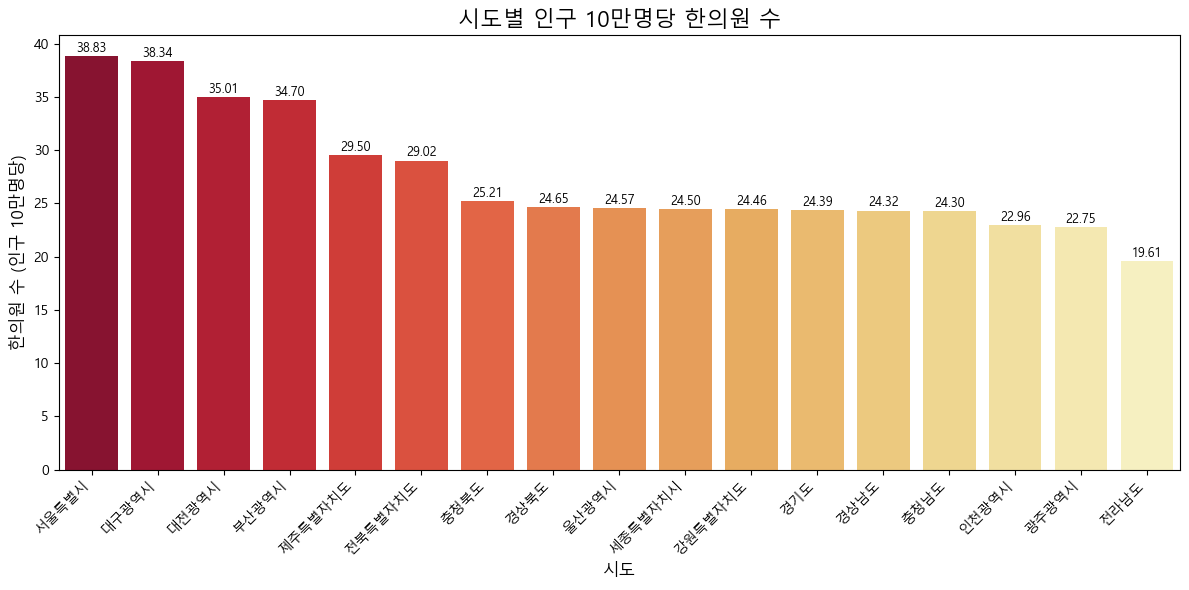

In [49]:
# 인구 10만명당 한의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sido,
    facility_name='한의원',
    unit=100000
)

##### 9) 인구 10만명 대비 약국수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\73119675.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x='Sido', y=col_name, palette=palette)


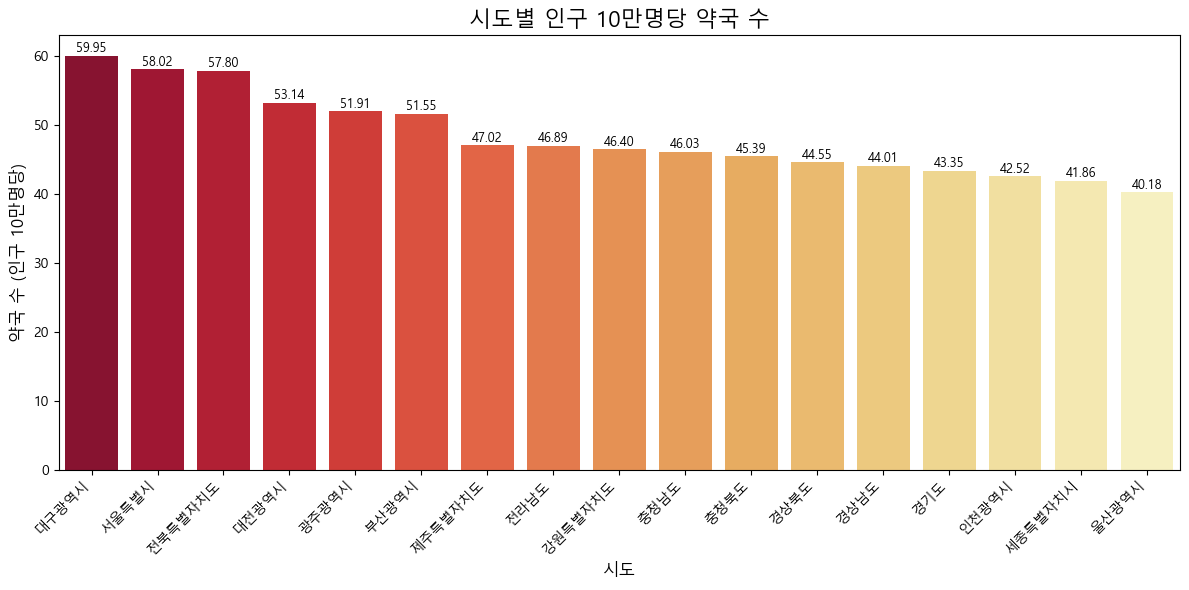

In [50]:
# 인구 10만명당 약국 수 시각화
plot_facility_per_population(
    facility_df=ph_df_f,
    pop_df=pop_by_sido,
    facility_name='약국',
    unit=100000
)

#### 5-1-2) 시군구에 대한 의료기관 통계 (상위 15개만 추출)

##### 1) 인구 100만명 대비 종합병원수

In [51]:
# 시군구별 인구 데이터 준비
pop_by_sigungu = pl_df_f.groupby('Sigungu')['pl_count'].sum().reset_index()

# 의료기관 통계 및 시각화를 위한 사용자 정의 함수
def plot_facility_per_population(
    facility_df,               # 병원/약국/시설 데이터프레임
    pop_df,                    # 인구 데이터프레임 (Sido, pl_count 필요)
    facility_name,             # 필터링할 시설 이름 (예: '한의원', '요양병원')
    unit=100000,               # 인구 기준 단위 (예: 100000 → 10만명당)
    palette='YlOrRd_r'           # 색상 팔레트
):
    # 시설 필터링
    filtered = facility_df[facility_df['dutyDivNam'] == facility_name]

    # 시군구별 시설 수 집계
    count_by_sigungu = filtered.groupby('Sigungu').size().reset_index(name='facility_count')

    # 병합: 시군구별 인구 수와 시설 수
    merged = pd.merge(count_by_sigungu, pop_df, on='Sigungu')

    # 인구 단위당 시설 수 계산
    col_name = f'{facility_name}_per_{unit//10000}만명'
    merged[col_name] = (merged['facility_count'] / merged['pl_count'] * unit).round(2)

    # 정렬
    merged = merged.sort_values(by=col_name, ascending=False)
    
    # 기존 merged 데이터에서 상위 15개만 추출
    merged_top = merged.head(15)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)

    plt.title(f'시군구별 인구 {unit//10000}만명당 {facility_name} 수', fontsize=16)
    plt.ylabel(f'{facility_name} 수 (인구 {unit//10000}만명당)', fontsize=12)
    plt.xlabel('시군구', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    for i, val in enumerate(merged_top[col_name]):
        plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


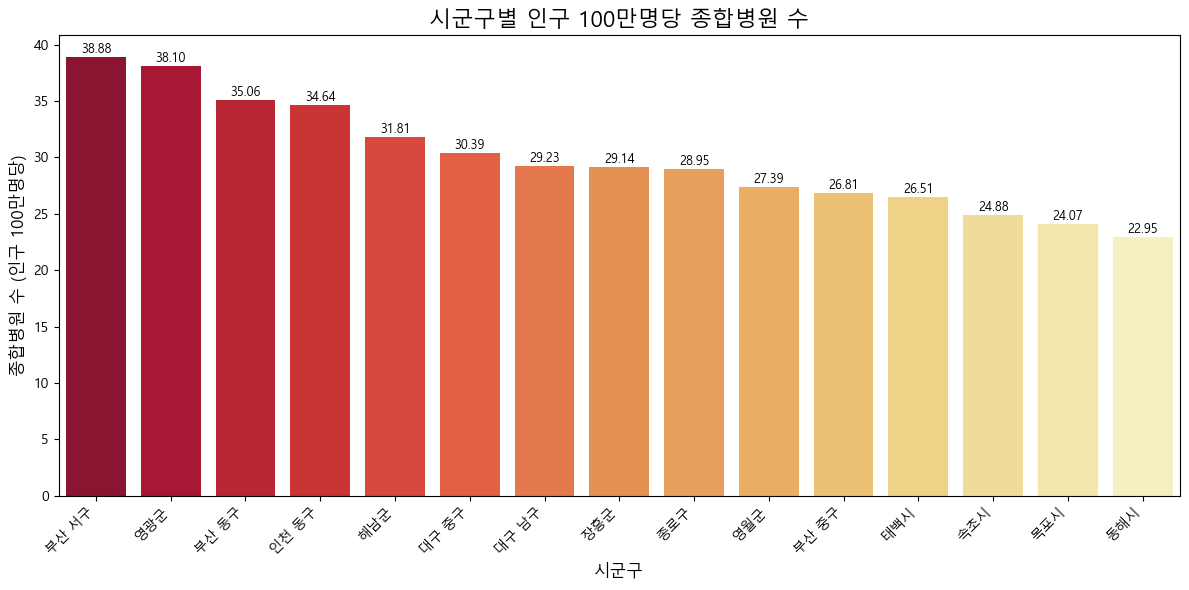

In [52]:
# 인구 100만 명당 종합병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='종합병원',
    unit=1000000
)

##### 2) 인구 100만명 대비 병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


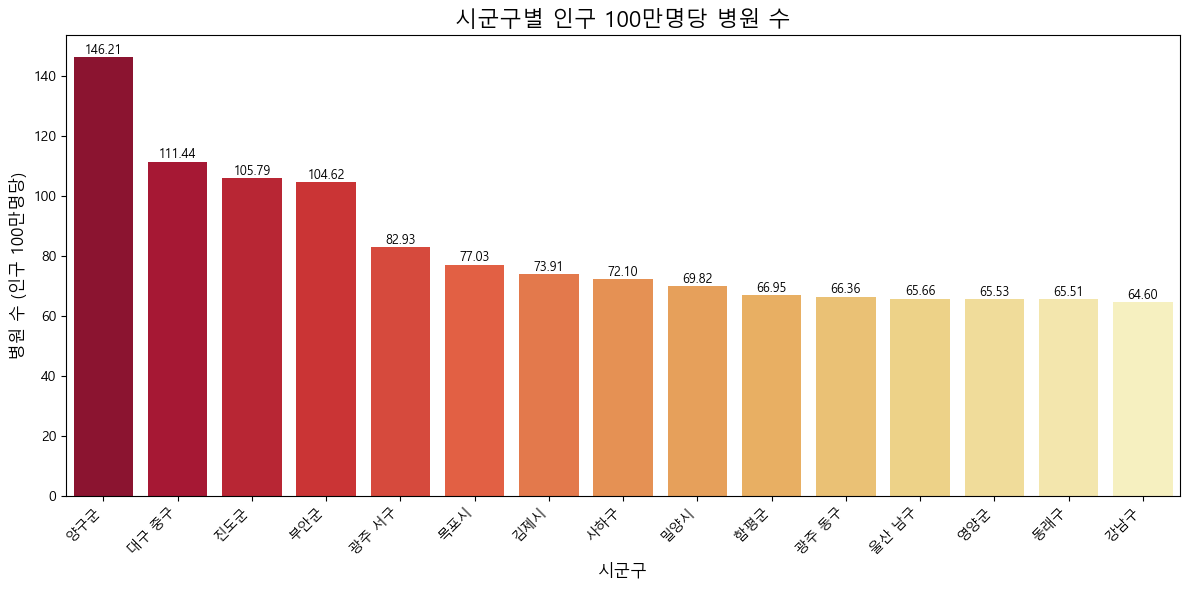

In [53]:
# 인구 100만 명당 병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='병원',
    unit=1000000
)

##### 3) 인구 1만명 대비 의원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


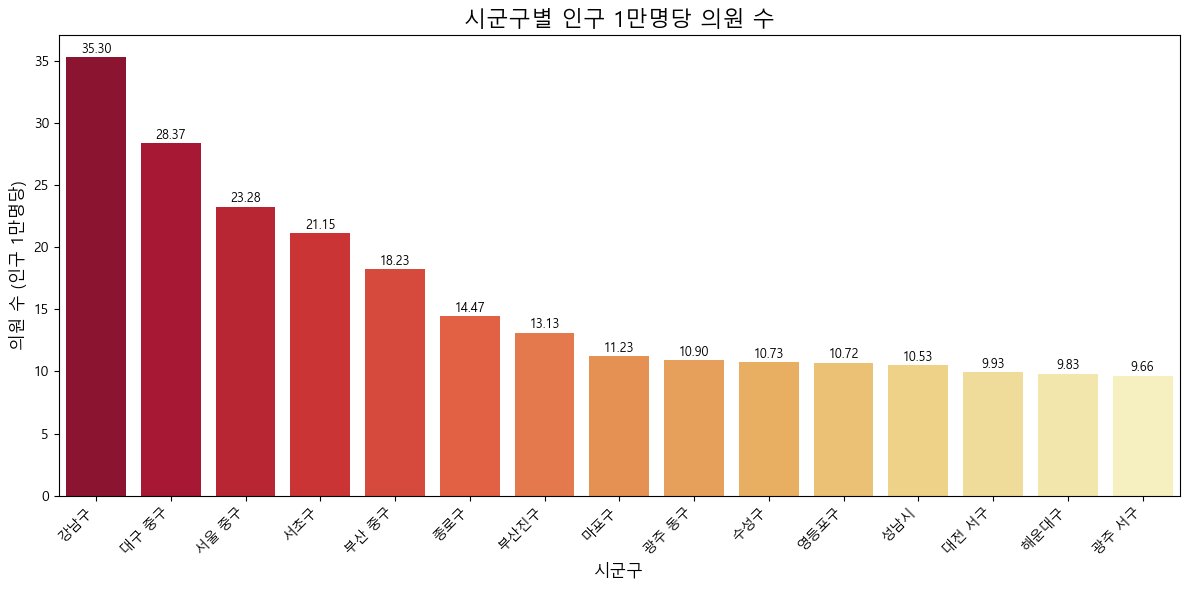

In [54]:
# 인구 1만 명당 의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='의원',
    unit=10000
)

##### 4) 인구 100만명 대비 치과병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


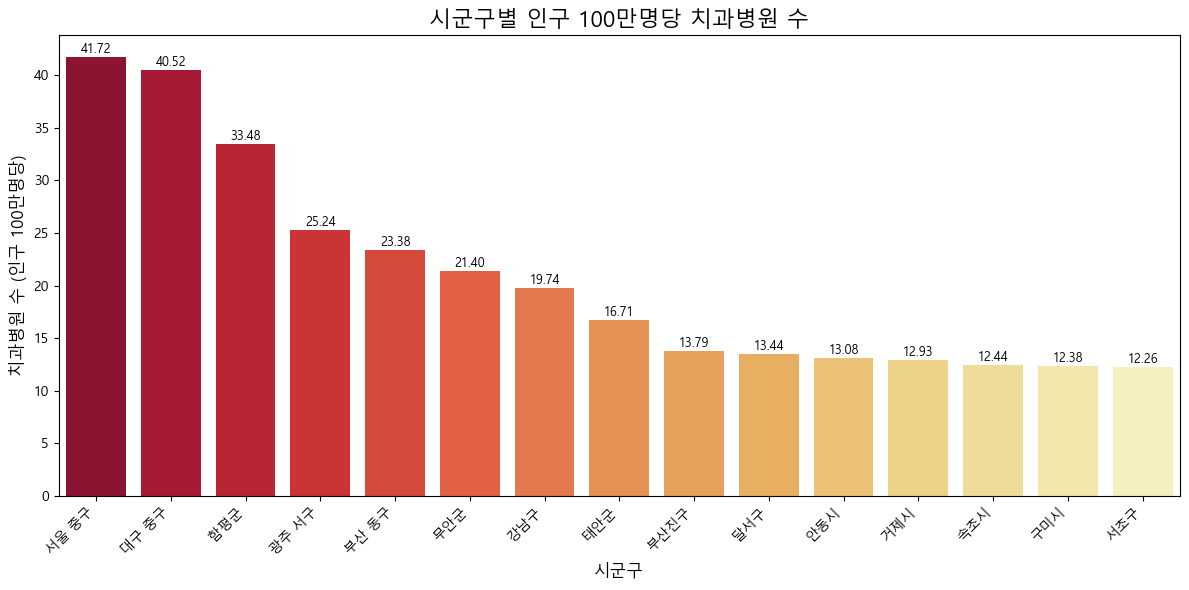

In [55]:
# 인구 100만 명당 치과병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과병원',
    unit=1000000
)

##### 5) 인구 10만명 대비 치과의원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


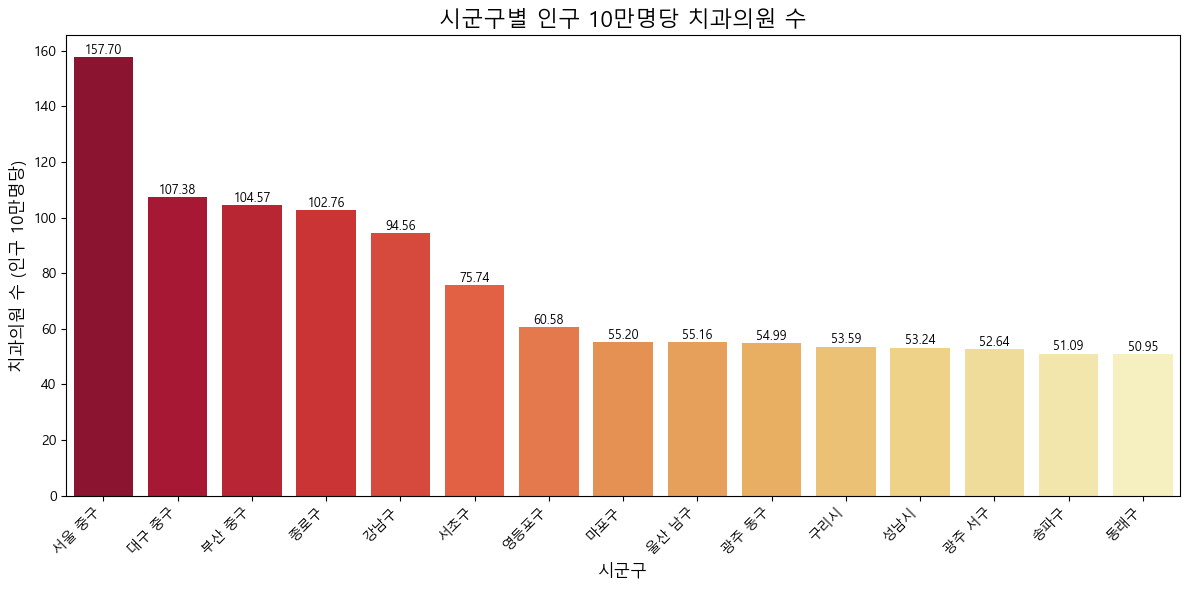

In [56]:
# 인구 10만 명당 치과의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과의원',
    unit=100000
)

##### 6) 인구 100만명 대비 치과병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


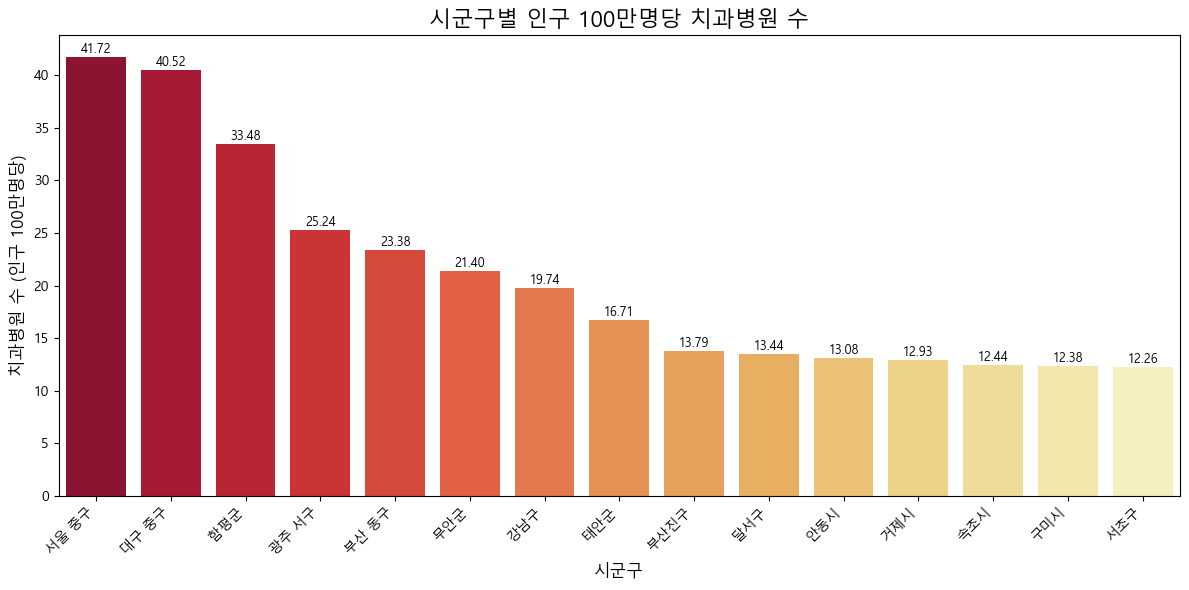

In [57]:
# 인구 100만 명당 치과병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='치과병원',
    unit=1000000
)

##### 7) 인구 100만명 대비 한방병원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


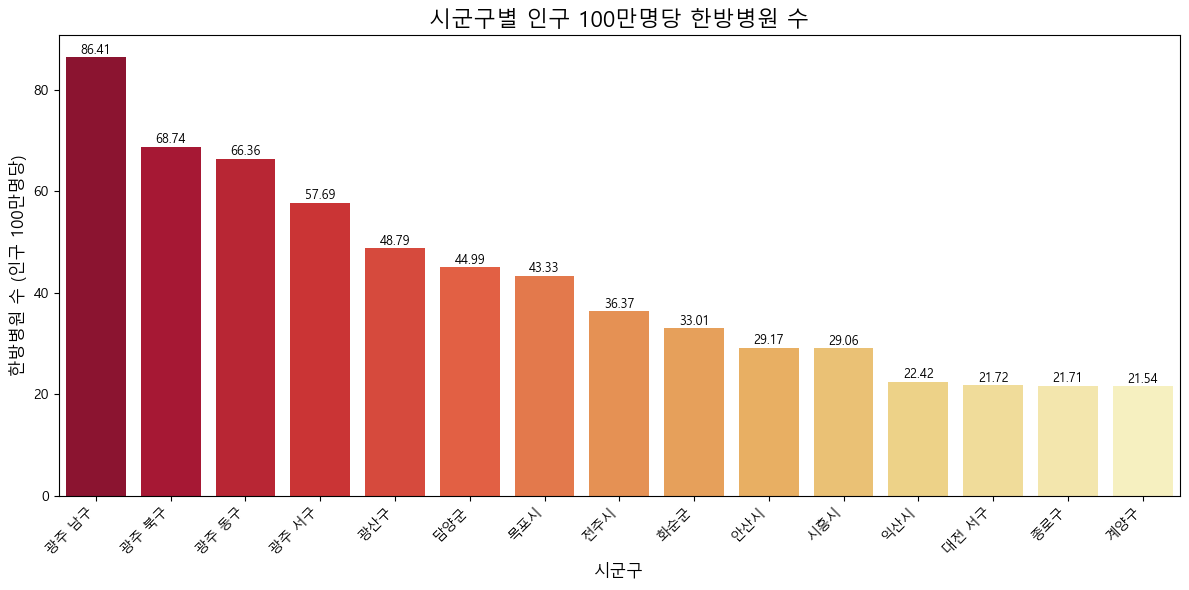

In [58]:
# 인구 100만 명당 한방병원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='한방병원',
    unit=1000000
)

##### 8) 인구 10만명 대비 한의원수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


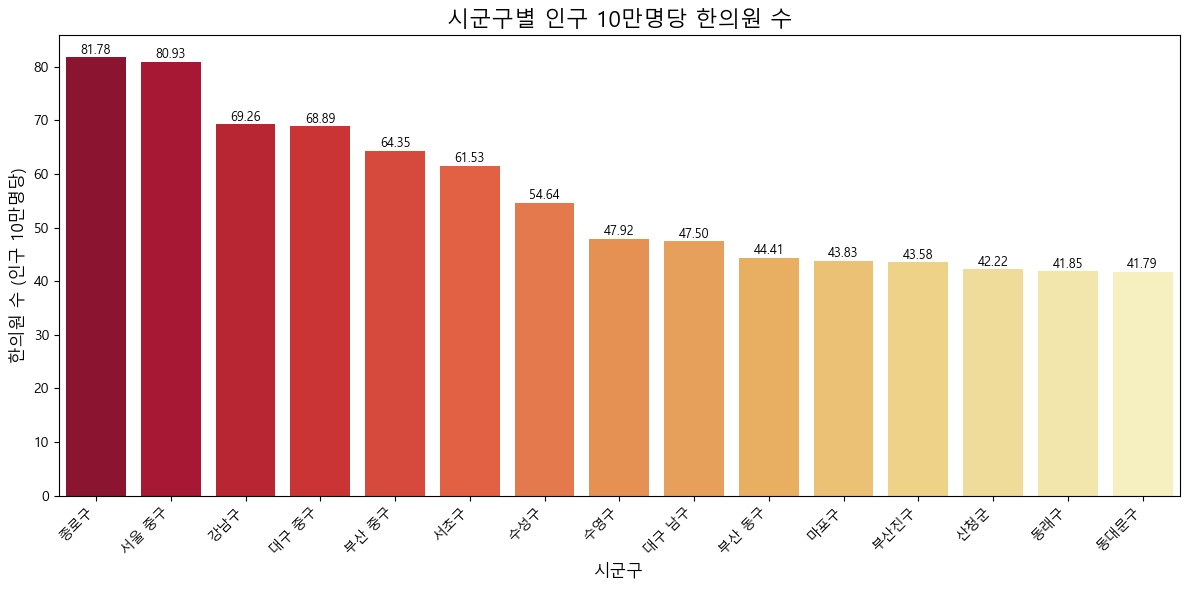

In [59]:
# 인구 10만 명당 한의원 수 시각화
plot_facility_per_population(
    facility_df=hos_df_f,
    pop_df=pop_by_sigungu,
    facility_name='한의원',
    unit=100000
)

##### 9) 인구 10만명 대비 약국수

C:\Users\QQQ\AppData\Local\Temp\ipykernel_12040\3441851586.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_top, x='Sigungu', y=col_name, palette=palette)


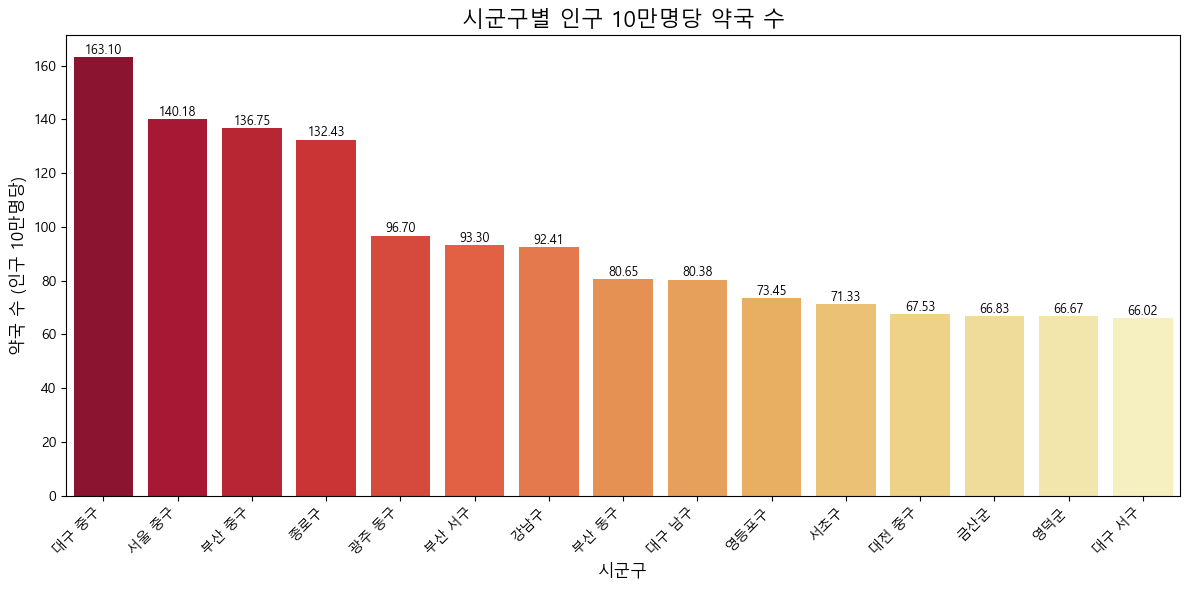

In [60]:
# 인구 10만명당 약국 수 시각화
plot_facility_per_population(
    facility_df=ph_df_f,
    pop_df=pop_by_sigungu,
    facility_name='약국',
    unit=100000
)

### 5-2) 고령 인구 관련 Feature

#### 5-2-1) 시도 단위 집계 고령 인구

In [61]:
# total_pop / pl_count	전체 인구
# aged_65_plus	65세 이상 인구 수
# aged_ratio	65세 이상 비율 (aged_65_plus / total_pop × 100)
# super_aged_area	aged_ratio > 20%이면 1, 아니면 0 (초고령 지역 여부 플래그)

# 고령 인구 컬럼 이름 변경
pl_df_f.rename(columns={'고령 인구': 'aged_65_plus'}, inplace=True)

# 고령 인구 비율 계산
pl_df_f['aged_ratio'] = (pl_df_f['aged_65_plus'] / pl_df_f['pl_count'] * 100).round(2)

# 초고령 지역 여부 라벨링 (20% 이상)
pl_df_f['super_aged_area'] = pl_df_f['aged_ratio'].apply(lambda x: 1 if x >= 20 else 0)

# 시도 단위 집계
aged_pop_by_sido = pl_df_f.groupby(['Sido'])[['pl_count', 'aged_65_plus']].sum().reset_index()

# 시도별 aged_ratio 계산
aged_pop_by_sido['aged_ratio'] = (
    aged_pop_by_sido['aged_65_plus'] / aged_pop_by_sido['pl_count'] * 100
).round(2)

# aged_ratio 기준으로 내림차순 정렬 후 상위 5개 확인
aged_pop_by_sido.sort_values(by='aged_ratio', ascending=False)

,Sido,pl_count,aged_65_plus,aged_ratio
12,전라남도,1785193,491208,27.52
3,경상북도,2523173,667063,26.44
0,강원특별자치도,1512969,390774,25.83
13,전북특별자치도,1733574,444211,25.62
7,부산광역시,3259219,791106,24.27
15,충청남도,2135628,483053,22.62
16,충청북도,1590512,354120,22.26
2,경상남도,3219574,715162,22.21
5,대구광역시,2360493,500067,21.18
8,서울특별시,9335734,1840543,19.72


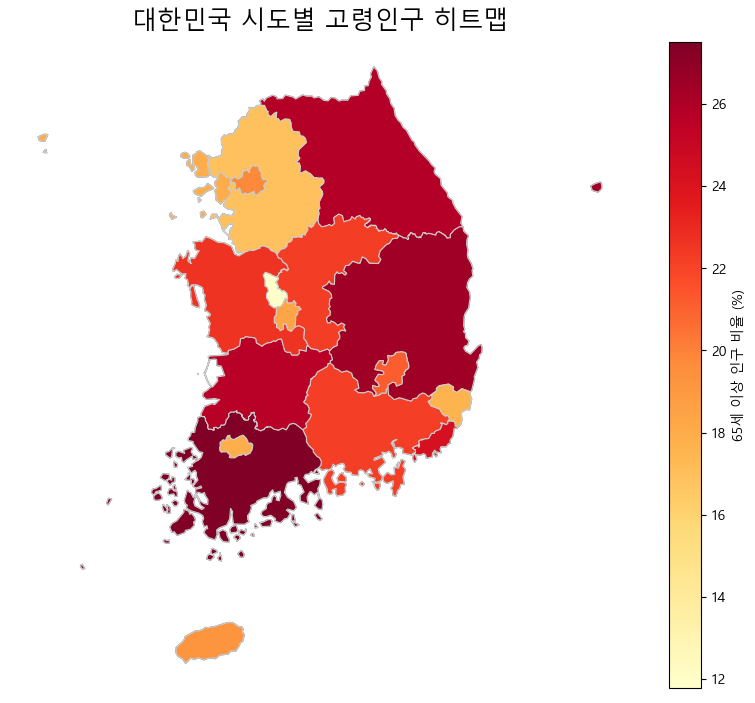

In [63]:
# 시도별 고령화 히트맵

# 지도 데이터 불러오기 (GeoJSON)
gdf_sido = gpd.read_file("C:/Users/QQQ/Desktop/TeamMG/TL_SCCO_CTPRVN.json")

# 강원특별자치도, 전북특별자치도를 강원도, 전라북도로 변경
aged_pop_by_sido_f = aged_pop_by_sido.copy()
aged_pop_by_sido_f['Sido'] = aged_pop_by_sido_f['Sido'].replace({
    '강원특별자치도' : '강원도',
    '전북특별자치도' : '전라북도'
})


# 지도 데이터와 aged_ratio 데이터 병합
merged = gdf_sido.merge(aged_pop_by_sido_f, left_on='CTP_KOR_NM', right_on='Sido')

# 히트맵(Choropleth) 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sido.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)

merged = gdf_sido.merge(aged_pop_by_sido_f, left_on='CTP_KOR_NM', right_on='Sido')
merged.plot(
    column='aged_ratio',
    cmap='YlOrRd',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "65세 이상 인구 비율 (%)",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시도별 고령인구 히트맵', fontsize=18)
ax.axis('off')
plt.show()

#### 5-2-2) 시군구 단위 집계 고령 인구

In [71]:
# 시도 단위 집계
aged_pop_by_sigungu = pl_df_f.groupby(['Sido', 'Sigungu'])[['pl_count', 'aged_65_plus']].sum().reset_index()

# 시군구별 aged_ratio 계산
aged_pop_by_sigungu['aged_ratio'] = (
    aged_pop_by_sigungu['aged_65_plus'] / aged_pop_by_sigungu['pl_count'] * 100
).round(2)

# aged_ratio 기준으로 내림차순 정렬 후 상위 5개 확인
aged_pop_by_sigungu.sort_values(by='aged_ratio', ascending=False)

,Sido,Sigungu,pl_count,aged_65_plus,aged_ratio
84,경상북도,의성군,48456,23315,48.12
94,대구광역시,군위군,22444,10729,47.80
166,전라남도,고흥군,60052,27611,45.98
66,경상남도,합천군,39869,18280,45.85
85,경상북도,청도군,40437,18115,44.80
...,...,...,...,...,...
39,경기도,오산시,244284,30345,12.42
89,광주광역시,광산구,389450,48209,12.38
152,울산광역시,울산 북구,215755,26099,12.10
149,세종특별자치시,세종시,391812,46135,11.77


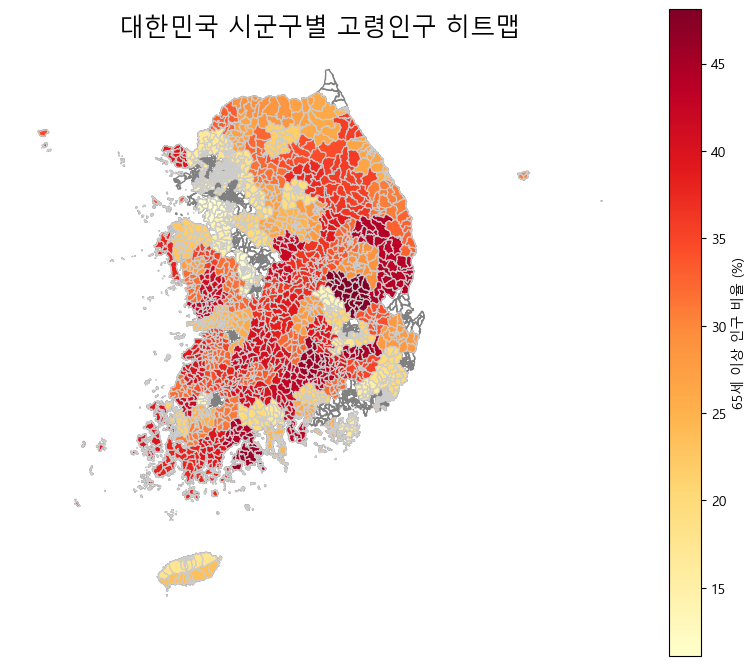

In [73]:
# 시군구별 고령화 히트맵

# 지도 데이터 불러오기
gdf_sig = gpd.read_file("C:/Users/QQQ/Downloads/HangJeongDong_ver20250401.geojson")

# 지도 데이터와 aged_ratio 데이터 병합
# GeoJSON의 'sggnm' <-> 데이터프레임의 '시군구명' 컬럼 기준
merged = gdf_sig.merge(
    aged_pop_by_sigungu,
    left_on='sggnm',        # GeoJSON 시군구명 컬럼
    right_on='Sigungu'       # 데이터프레임 시군구명 컬럼
)

# 히트맵(Choropleth) 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sig.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)  # 전체 윤곽선

merged.plot(
    column='aged_ratio',
    cmap='YlOrRd',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "65세 이상 인구 비율 (%)",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시군구별 고령인구 히트맵', fontsize=18)
ax.axis('off')
plt.show()

### 5-3) 종합 분석

#### 5-3-1) 시도에 대한 병원수/약국 밀도: 인구 1만명 당 병원, 약국수

In [69]:
# 시도별 병원/약국 수, 인구 수 집계
# 시도별 병원 수 집계
hos_count_by_sido = hos_df_f.groupby('Sido').size().reset_index(name='hos_count')

# 시도별 약국 수 집계
ph_count_by_sido = ph_df_f.groupby('Sido').size().reset_index(name='ph_count')

# pl_df_f의 '계' 열의 이름을 'Count'로 변경
pl_df_f.rename(columns={'계': 'pl_count'}, inplace=True)

# 시도별 인구 수 집계
pop_by_sido = pl_df_f.groupby('Sido')['pl_count'].sum().reset_index()

In [70]:
# 병원/약국/인구 데이터 병합
# 병원 + 약국 병합
facility_by_sido = pd.merge(hos_count_by_sido, ph_count_by_sido, on='Sido', how='outer')

# 인구와 병합
merged_by_sido = pd.merge(facility_by_sido, pop_by_sido, on='Sido', how='left')

병원 밀도 기준으로 오름차순 정렬

In [74]:
# 밀도계산: 인구 100만명당 병원/약국 수 rate: 비율
merged_by_sido['hos_rate'] = (merged_by_sido['hos_count'] / merged_by_sido['pl_count'] * 10000).round(2)
merged_by_sido['ph_rate'] = (merged_by_sido['ph_count'] / merged_by_sido['pl_count'] * 10000).round(2)

# 병원 밀도 기준으로 오름차순 정렬
result_by_sido = merged_by_sido.sort_values(by='hos_rate', ascending=True)

df_result = result_by_sido[['Sido', 'pl_count', 'hos_count', 'hos_rate']].copy()
df_result

,Sido,pl_count,hos_count,hos_rate
9,세종특별자치시,391812,454,11.59
11,인천광역시,3031361,3829,12.63
0,강원특별자치도,1512969,1947,12.87
10,울산광역시,1095014,1410,12.88
1,경기도,13699381,17720,12.93
2,경상남도,3219574,4191,13.02
15,충청남도,2135628,2829,13.25
3,경상북도,2523173,3361,13.32
16,충청북도,1590512,2181,13.71
12,전라남도,1785193,2594,14.53


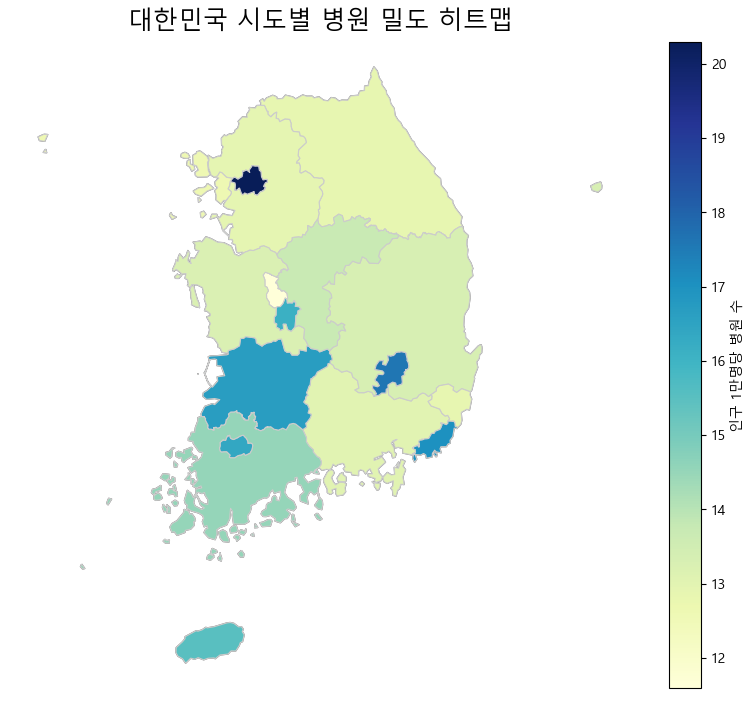

In [75]:
# 인구 1만명당 시도별 병원 밀도 히트맵

# 시도 경계 GeoJSON 파일 불러오기
gdf_sido = gpd.read_file("C:/Users/QQQ/Desktop/TeamMG/TL_SCCO_CTPRVN.json")

# 강원특별자치도, 전북특별자치도를 강원도, 전라북도로 변경
df_result_f = df_result.copy()
df_result_f['Sido'] = df_result_f['Sido'].replace({
    '강원특별자치도' : '강원도',
    '전북특별자치도' : '전라북도'
})

# 병원 밀도 데이터와 지도 데이터 병합
merged = gdf_sido.merge(df_result_f, left_on='CTP_KOR_NM', right_on='Sido')

# 전체 지도 윤곽선 먼저 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sido.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)

# 병합된 데이터(병원 밀도)로 히트맵 덮어씌우기
merged.plot(
    column='hos_rate',
    cmap='YlGnBu',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "인구 1만명당 병원 수",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시도별 병원 밀도 히트맵', fontsize=18)
ax.axis('off')
plt.show()

약국 비율 기준으로 오름차순 정렬

In [78]:
# 약국 비율 기준으로 오름차순 정렬
result_by_sido = merged_by_sido.sort_values(by='ph_rate', ascending=True)

df_result = result_by_sido[['Sido', 'pl_count', 'ph_count', 'ph_rate']].copy()
df_result

,Sido,pl_count,ph_count,ph_rate
10,울산광역시,1095014,440,4.02
9,세종특별자치시,391812,164,4.19
11,인천광역시,3031361,1289,4.25
1,경기도,13699381,5939,4.34
2,경상남도,3219574,1417,4.40
3,경상북도,2523173,1124,4.45
16,충청북도,1590512,722,4.54
15,충청남도,2135628,983,4.60
0,강원특별자치도,1512969,702,4.64
12,전라남도,1785193,837,4.69


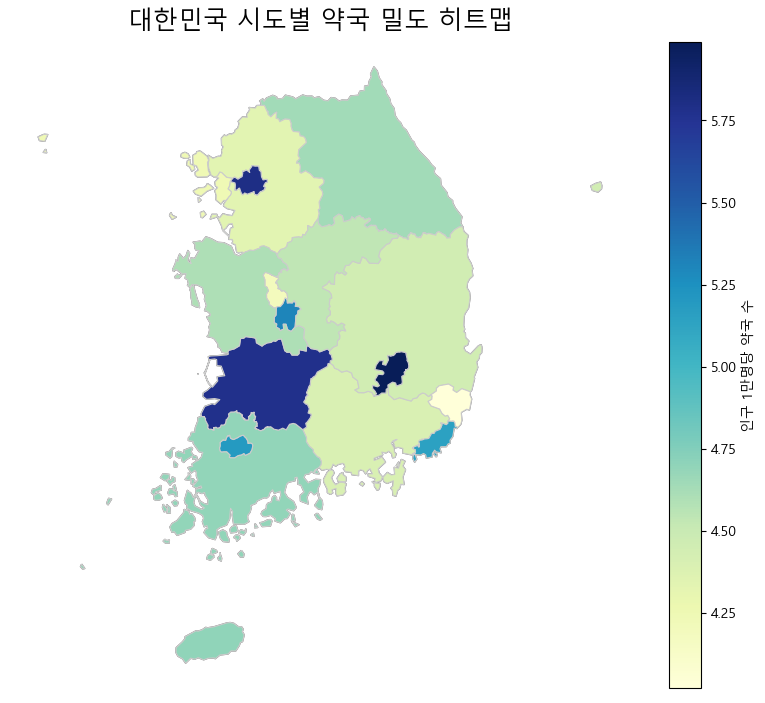

In [77]:
# 인구 1만명당 시도별 약국 밀도 히트맵

#  강원특별자치도, 전북특별자치도를 강원도, 전라북도로 변경
df_result_f = df_result.copy()
df_result_f['Sido'] = df_result_f['Sido'].replace({
    '강원특별자치도' : '강원도',
    '전북특별자치도' : '전라북도'
})

# 약국 밀도 데이터와 지도 데이터 병합
merged = gdf_sido.merge(df_result_f, left_on='CTP_KOR_NM', right_on='Sido')

# 전체 지도 윤곽선 먼저 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sido.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)

# 병합된 데이터(약국 밀도)로 히트맵 덮어씌우기
merged.plot(
    column='ph_rate',
    cmap='YlGnBu',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "인구 1만명당 약국 수",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시도별 약국 밀도 히트맵', fontsize=18)
ax.axis('off')
plt.show()

#### 5-3-1) 시군구에 대한 병원 수/약국 밀도: 인구 1만명당 병원, 약국수

In [79]:
# 시도 + 시군구 단위 병원 수 집계
hos_count_by_sigungu = hos_df_f.groupby(['Sido', 'Sigungu']).size().reset_index(name='hos_count')

# 시도 + 시군구 단위 약국 수 집계
ph_count_by_sigungu = ph_df_f.groupby(['Sido', 'Sigungu']).size().reset_index(name='ph_count')
 
# 시도 + 시군구 단위 인구 수 집계
pop_by_sigungu = pl_df_f.groupby(['Sido', 'Sigungu'])['pl_count'].sum().reset_index()

In [80]:
# 병원/약국/인구 데이터 병합
# 병원 + 약국 병합
facility_by_sigungu = pd.merge(hos_count_by_sigungu, ph_count_by_sigungu, on='Sigungu', how='outer')

# 인구와 병합
merged_by_sigungu = pd.merge(facility_by_sigungu, pop_by_sigungu, on='Sigungu', how='left')

병원 비율 기준으로 오름차순 정렬

In [81]:
# 비율계산: 인구 1만명당 병원/약국 수
merged_by_sigungu['hos_rate'] = (merged_by_sigungu['hos_count'] / merged_by_sigungu['pl_count'] * 10000).round(2)
merged_by_sigungu['ph_rate'] = (merged_by_sigungu['ph_count'] / merged_by_sigungu['pl_count'] * 10000).round(2)

# 병원 비율 기준으로 오름차순 정렬
result_by_sigungu = merged_by_sigungu.sort_values(by='hos_rate', ascending=True)

df_result = result_by_sigungu[['Sido', 'Sigungu', 'pl_count', 'hos_count', 'hos_rate']].copy()
df_result

df_result.to_excel("C:/Users/QQQ/Desktop/df_result.xlsx", index=False)

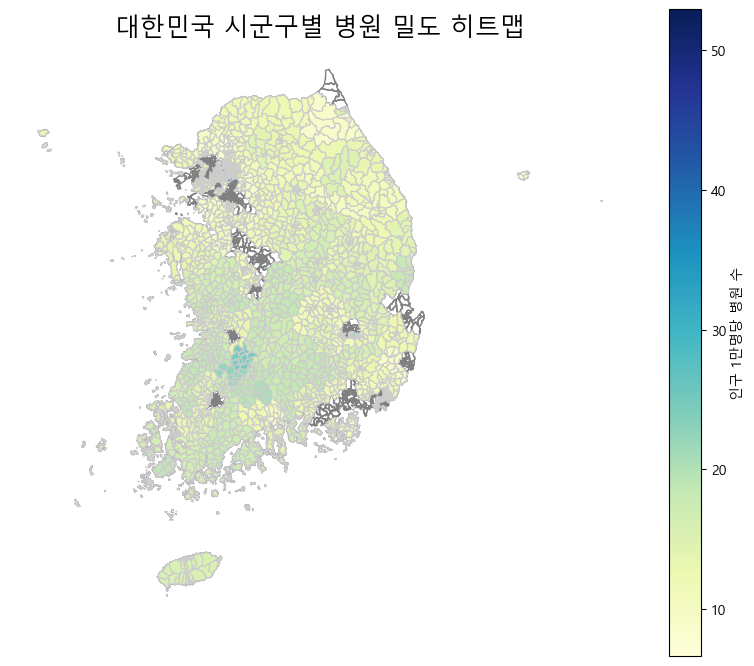

In [82]:
# 인구 1만명당 시군구별 병원 밀도

# 지도 데이터 불러오기
gdf_sig = gpd.read_file("C:/Users/QQQ/Downloads/HangJeongDong_ver20250401.geojson")

# 병원 밀도 데이터와 지도 데이터 병합
merged = gdf_sig.merge(
    df_result,
    left_on='sggnm',        # GeoJSON 시군구명 컬럼
    right_on='Sigungu'       # 데이터프레임 시군구명 컬럼
)

# 전체 지도 윤곽선 먼저 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sig.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)

# 병합된 데이터(병원 밀도)로 히트맵 덮어씌우기
merged.plot(
    column='hos_rate',
    cmap='YlGnBu',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "인구 1만명당 병원 수",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시군구별 병원 밀도 히트맵', fontsize=18)
ax.axis('off')
plt.show()

약국 비율 기준으로 오름차순 정렬

In [83]:
# 약국 비율 기준으로 오름차순 정렬
result_by_sigungu = merged_by_sigungu.sort_values(by='ph_rate', ascending=True)

df_result = result_by_sigungu[['Sido', 'Sigungu', 'pl_count', 'ph_count', 'ph_rate']].copy()
df_result.head(10)

,Sido,Sigungu,pl_count,ph_count,ph_rate
123,전라남도,신안군,38694,7,1.81
154,인천광역시,옹진군,19796,4,2.02
159,경상북도,울릉군,9040,2,2.21
146,경상북도,영양군,15261,4,2.62
162,울산광역시,울산 북구,215755,58,2.69
172,경기도,의왕시,153951,47,3.05
86,부산광역시,부산 강서구,142703,44,3.08
164,울산광역시,울주군,218402,68,3.11
38,대구광역시,군위군,22444,7,3.12
151,경상북도,예천군,54301,17,3.13


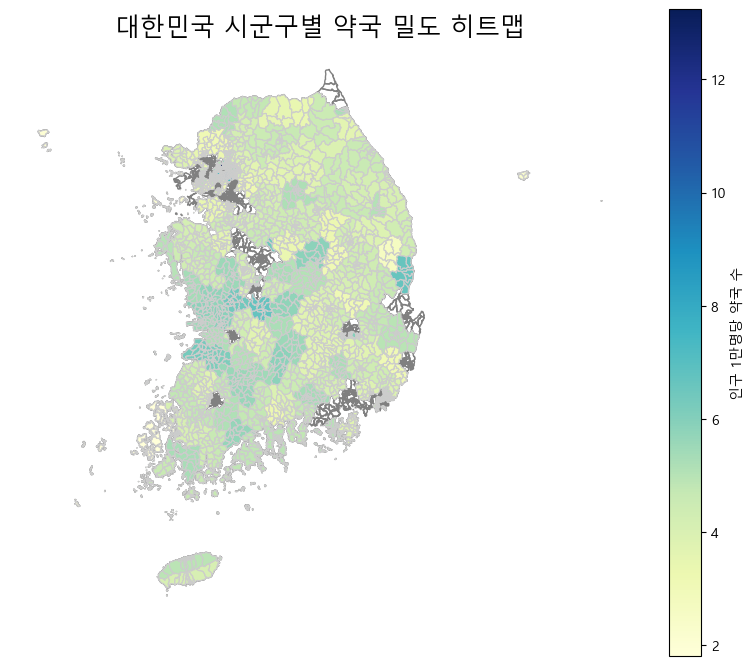

In [84]:
# 인구 1만명당 시군구별 약국 밀도

# 지도 데이터 불러오기
gdf_sig = gpd.read_file("C:/Users/QQQ/Downloads/HangJeongDong_ver20250401.geojson")

# 병원 밀도 데이터와 지도 데이터 병합
merged = gdf_sig.merge(
    df_result,
    left_on='sggnm',
    right_on='Sigungu'
)

# 전체 지도 윤곽선 먼저 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_sig.plot(facecolor='none', edgecolor='gray', linewidth=1, ax=ax)

# 병합된 데이터(병원 밀도)로 히트맵 덮어씌우기
merged.plot(
    column='ph_rate',
    cmap='YlGnBu',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "인구 1만명당 약국 수",
                 'shrink': 0.7
                 }
)

ax.set_title('대한민국 시군구별 약국 밀도 히트맵', fontsize=18)
ax.axis('off')
plt.show()

## 6. 모델링

공공보건의료에 관한 법률 제12조(의료취약지의 지정ㆍ고시) 
  1. 인구 수, 성별ㆍ연령별 인구 분포, 소득 등에 따른 지역 내 국민의 의료 이용 실태에 관한 사항
  2. 의료인력ㆍ의료기관의 수 등 지역 내 의료공급에 관한 사항
  3. 지역적 특성 등을 고려한 의료기관 접근성에 관한 사항
  4. 그 밖에 의료 이용 실태 및 의료자원 공급에 관한 사항으로서 보건복지부장관이 정하는 사항

### 6-1) 클러스터링 기반 지역 유형 분류 모델링 (KMeans 클러스터링 알고리즘)
- 목표: 비슷한 지역들끼리 자동으로 그룹화하고, 이를 기반으로 지역 유형 분석

In [85]:
# 병원 + 약국 병합
infra_detail_df = pd.concat([hos_df_f, ph_df_f], ignore_index=True)

# 약국 데이터: '의료기관구분'이 1이고, 'dutyDivNam'에 '약국'이 포함된 경우
ph_df = infra_detail_df[
    (infra_detail_df['의료기관구분'] == 1) &
    (infra_detail_df['dutyDivNam'].str.contains('약국', na=False))
]

# 병원 데이터: 나머지 전부 (즉, 약국을 제외한 것)
hos_df = infra_detail_df.drop(ph_df.index)

# 병원 수 집계
hos_count = hos_df.groupby(['Sido', 'Sigungu']).size().reset_index(name='hos_count')

# 약국 수 집계
ph_count = ph_df.groupby(['Sido', 'Sigungu']).size().reset_index(name='ph_count')

# 인구 기반 데이터와 병합
infra_df = pl_df_f.merge(hos_count, on=['Sido', 'Sigungu'], how='left')
infra_df = infra_df.merge(ph_count, on=['Sido', 'Sigungu'], how='left')
infra_df.fillna({'hos_count': 0, 'ph_count': 0}, inplace=True)

# 접근성 지표 계산
infra_df['hospital_per_1000_aged'] = infra_df['hos_count'] / (infra_df['aged_65_plus'] / 1000 + 1)
infra_df['pharmacy_per_1000_aged'] = infra_df['ph_count'] / (infra_df['aged_65_plus'] / 1000 + 1)

# aged_ratio 추가
infra_df['aged_ratio'] = (infra_df['aged_65_plus'] / infra_df['pl_count'] * 100).round(2)

# 하위 25% 기준
threshold_hos = infra_df['hospital_per_1000_aged'].quantile(0.25)
threshold_ph = infra_df['pharmacy_per_1000_aged'].quantile(0.25)

infra_df['maybe_vulnerable_hos'] = infra_df['hospital_per_1000_aged'] < threshold_hos
infra_df['maybe_vulnerable_ph'] = infra_df['pharmacy_per_1000_aged'] < threshold_ph

infra_detail_df['의료기관구분'].value_counts()

의료기관구분
1    98476
2     3961
0      164
3       44
Name: count, dtype: int64

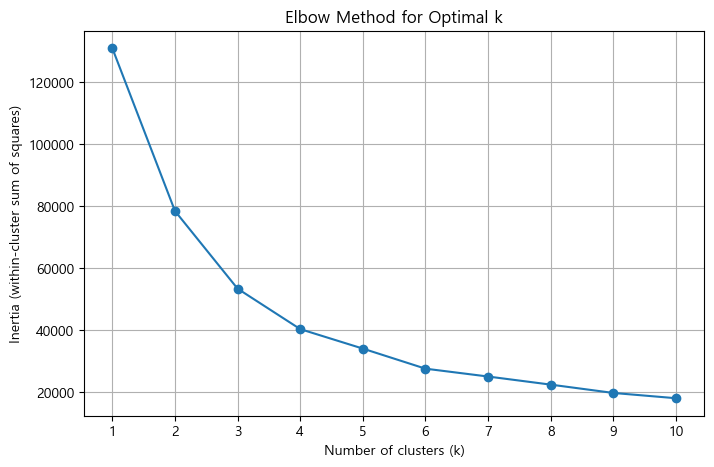

In [86]:
# 클러스터링에 사용할 변수 선택
cluster_features = [
    'pl_count', 'aged_65_plus', 'aged_ratio',
    'hos_count', 'ph_count', 'hospital_per_1000_aged', 'pharmacy_per_1000_aged'
]

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(infra_df[cluster_features])

# Elbow 기법용 inertia 저장
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [87]:
# 사용할 변수
cluster_features = [
    'pl_count', 'aged_65_plus', 'aged_ratio',
    'hos_count', 'ph_count', 'hospital_per_1000_aged', 'pharmacy_per_1000_aged'
]

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(infra_df[cluster_features])

# 최적 k=4로 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
infra_df['cluster'] = kmeans.fit_predict(X_scaled)

print("\n군집별 특성 평균값:")
cluster_summary = infra_df.groupby('cluster')[cluster_features].mean().round(2)
print(cluster_summary)


군집별 특성 평균값:
         pl_count  aged_65_plus  aged_ratio  hos_count  ph_count  \
cluster                                                            
0          357.39        149.02       49.01     107.08     34.09   
1         1965.16        388.87       36.51    1069.23    360.51   
2        53495.87       9777.18       18.68     837.28    263.05   
3         4119.63        750.00       30.46     394.25    137.85   

         hospital_per_1000_aged  pharmacy_per_1000_aged  
cluster                                                  
0                         94.36                   29.96  
1                        841.38                  285.46  
2                         98.20                   31.23  
3                        273.11                   96.00  


<Figure size 1200x600 with 0 Axes>

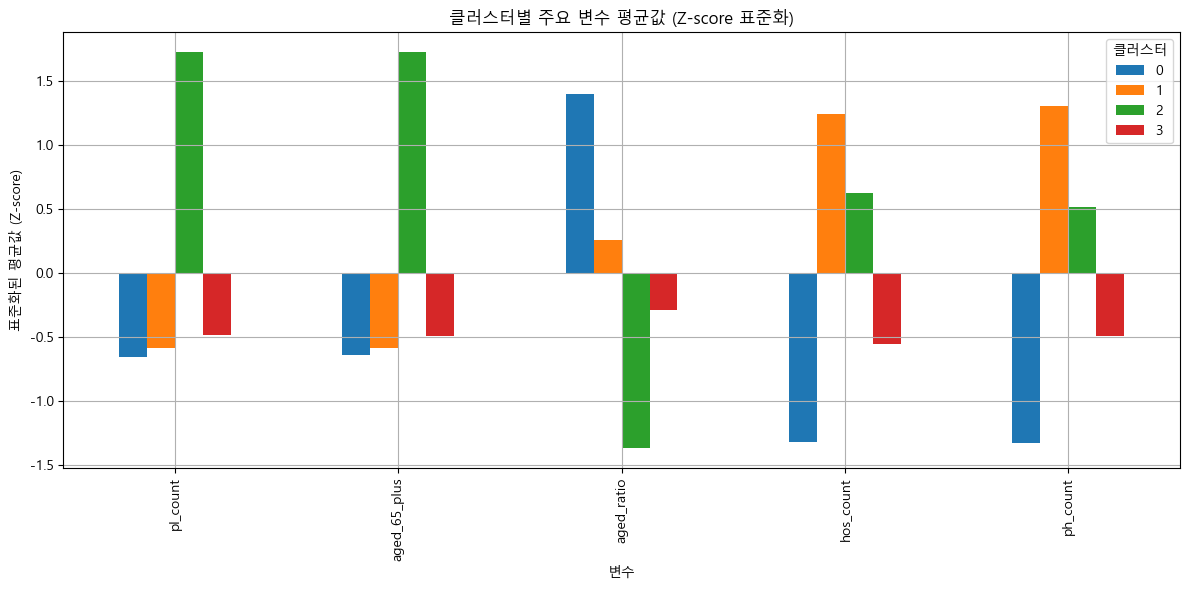

In [88]:
# 주요 변수 및 클러스터 컬럼
variables = [
    'pl_count', 'aged_65_plus', 'aged_ratio',
    'hos_count', 'ph_count'
]
cluster_col = 'cluster'

# 클러스터별 평균 계산
cluster_means = infra_df.groupby(cluster_col)[variables].mean()

# 표준화
scaler = StandardScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

# 바 그래프 시각화
plt.figure(figsize=(12, 6))
cluster_means_scaled.T.plot(kind='bar', figsize=(12, 6))
plt.title('클러스터별 주요 변수 평균값 (Z-score 표준화)')
plt.xlabel('변수')
plt.ylabel('표준화된 평균값 (Z-score)')
plt.legend(title='클러스터')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 클러스터0: 작은 인구 규모의 고령화 취약지역으로 예상
- aged_ratio가 가장 높음 -> 고령화 지역
- hos_count, ph_count가 모두 낮음 -> 의료자원 부족
- pl_count, aged_65_plus 모두 평균보다 낮음
#### 클러스터1: 도시형 비고령일 가능성
- hos_count, ph_count 모두 높음 -> 의료 인프라 풍부
- aged_ration 다소 낮음
#### 클러스터2: 대도시, 청장년 비중이 큰 지역으로 예상
- pl_count, aged_65_plus 모두 매우 높음
- aged_ration는 매우 낮음 -> 인구 대비 고령자 비율 낮음
#### 클러스터3: 인프라 낙후 지역, 또는 소규모 비고령 농촌지역으로 예상
- 전반적으로 모든 지표가 평균 이하
- aged_Ration도 낮고 병원, 약국 수 적음

In [89]:
# infra_df['cluster']의 범주와 개수
cluster_counts = infra_df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
print("infra_df['cluster']의 범주와 개수")
print(cluster_counts)

infra_df['cluster']의 범주와 개수
   cluster  count
0        0  12301
1        3   4318
2        1   1608
3        2    483


### 6-2) 의료취약지 예측 모델 개발 및 평가 - 고령인구 및 의료 접근성 기반 분류 분석
- 목표: 고령인구 비율과 의료 접근성 지표를 활용해 의료취약지를 예측하는 분류 모델 구축 및 평가

In [90]:
# 고령비율 높은데 병원 접근성 낮은 경우: 의료 취약지 조건 설정
infra_df['maybe_vulnerable'] = (
    (infra_df['aged_ratio'] > infra_df['aged_ratio'].quantile(0.75)) & # 상위 25% 고령 인구 비율이 높은 지역
    (infra_df['hospital_per_1000_aged'] < infra_df['hospital_per_1000_aged'].quantile(0.25)) & # 고령 인구 대비 병원 수가 적은 지역
    (infra_df['pharmacy_per_1000_aged'] < infra_df['pharmacy_per_1000_aged'].quantile(0.25)) # 고령 인구 대비 약국 수가 적은 지역
)


RandomForest (클러스터 미포함) 성능:
              precision    recall  f1-score   support

       False      0.985     0.989     0.987      3554
        True      0.782     0.723     0.751       188

    accuracy                          0.976      3742
   macro avg      0.884     0.856     0.869      3742
weighted avg      0.975     0.976     0.976      3742


RandomForest (클러스터 포함) 성능:
              precision    recall  f1-score   support

       False      0.985     0.989     0.987      3554
        True      0.778     0.707     0.741       188

    accuracy                          0.975      3742
   macro avg      0.881     0.848     0.864      3742
weighted avg      0.974     0.975     0.975      3742



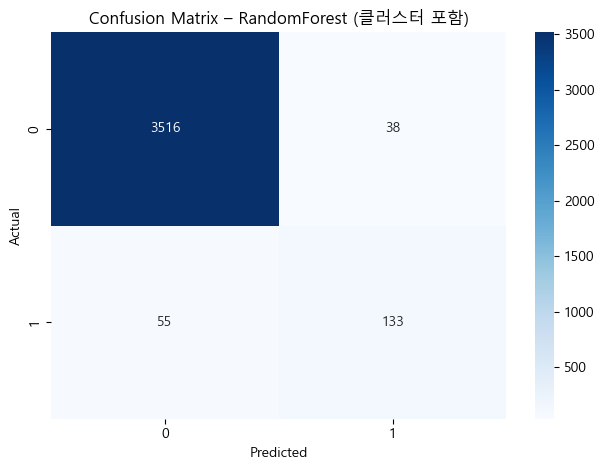

c:\Users\QQQ\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (클러스터 미포함) 성능:
              precision    recall  f1-score   support

       False      0.998     0.981     0.989      3554
        True      0.726     0.957     0.826       188

    accuracy                          0.980      3742
   macro avg      0.862     0.969     0.907      3742
weighted avg      0.984     0.980     0.981      3742


XGBoost (클러스터 포함) 성능:
              precision    recall  f1-score   support

       False      0.997     0.980     0.988      3554
        True      0.714     0.941     0.812       188

    accuracy                          0.978      3742
   macro avg      0.855     0.961     0.900      3742
weighted avg      0.983     0.978     0.980      3742



c:\Users\QQQ\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


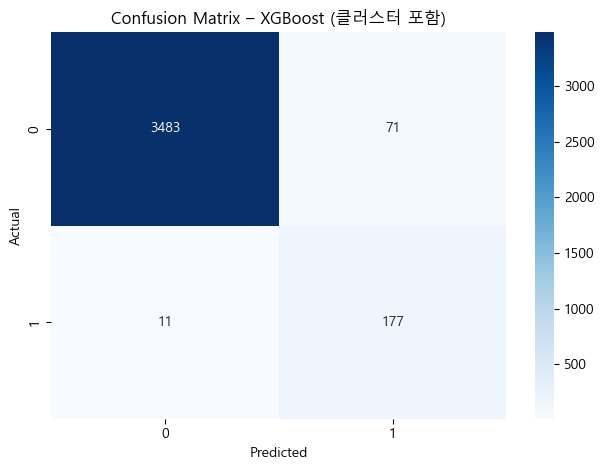

[LightGBM] [Info] Number of positive: 812, number of negative: 14156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 14968, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054249 -> initscore=-2.858394
[LightGBM] [Info] Start training from score -2.858394

LightGBM (클러스터 미포함) 성능:
              precision    recall  f1-score   support

       False      0.997     0.970     0.983      3554
        True      0.626     0.952     0.755       188

    accuracy                          0.969      3742
   macro avg      0.812     0.961     0.869      3742
weighted avg      0.979     0.969     0.972      3742

[LightGBM] [Info] Number of positive: 812, number of negative: 14156
[LightGBM] [Info] Auto-ch

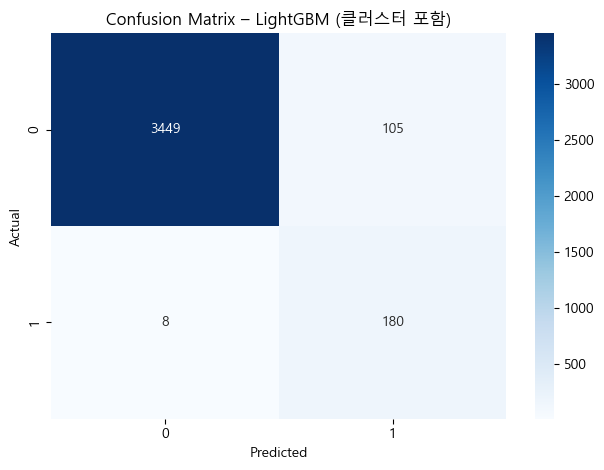

In [91]:
# target 및 features
target = 'maybe_vulnerable'
features_without_cluster = ['pl_count', 'aged_65_plus', 'ph_count', 'pharmacy_per_1000_aged']
features_with_cluster = features_without_cluster + ['cluster']

# 결측 제거
df_model = infra_df.dropna(subset=features_with_cluster + [target])
X_all = df_model[features_with_cluster]
y_all = df_model[target]

# train/test split (한 번만)
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 클러스터 미포함용 X
X1_train = X_train_all[features_without_cluster]
X1_test = X_test_all[features_without_cluster]

# 클러스터 포함용 X
X2_train = X_train_all
X2_test = X_test_all

# 클래스 불균형 비율 계산
scale_pos_weight = np.sum(y_all == 0) / np.sum(y_all == 1)

# 모델 정의
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    "LightGBM": LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
}

# 평가 함수
def train_and_evaluate(model, X_train, X_test, model_name, use_cluster=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    title = f"{model_name} ({'클러스터 포함' if use_cluster else '클러스터 미포함'})"
    print(f"\n{title} 성능:")
    print(classification_report(y_test, y_pred, digits=3))

    if use_cluster:
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix – {title}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# 모델 훈련 및 평가
for name, model in models.items():
    train_and_evaluate(model, X1_train, X1_test, name, use_cluster=False)
    train_and_evaluate(model, X2_train, X2_test, name, use_cluster=True)

c:\Users\QQQ\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 812, number of negative: 14156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 14968, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054249 -> initscore=-2.858394
[LightGBM] [Info] Start training from score -2.858394


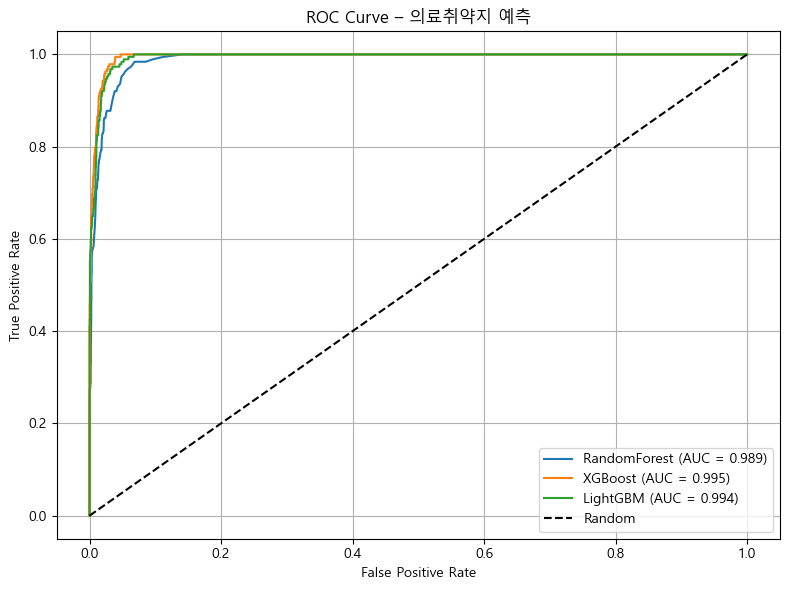

In [92]:
# 다시 학습 (클러스터 포함 데이터 사용)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
lgbm = LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

rf.fit(X2_train, y_train)
xgb.fit(X2_train, y_train)
lgbm.fit(X2_train, y_train)

def get_roc_curve(model, name):
    probs = model.predict_proba(X2_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score, name

roc_results = [
    get_roc_curve(rf, "RandomForest"),
    get_roc_curve(xgb, "XGBoost"),
    get_roc_curve(lgbm, "LightGBM")
]

# ROC Plot
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score, label in roc_results:
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – 의료취약지 예측")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. 이미지 시각화

### 7-1) 병원 및 약국 지도 생성

In [84]:
# 각 데이터 복사
hos_df = hos_df_f.copy() # 병원 데이터
ph_df = ph_df_f.copy() # 약국 데이터
pl_df = pl_df_f.copy() # 인구 데이터

# 병원/약국/보건소에 'type' 열 추가
hos_df['type'] = '병원'
ph_df['type'] = '약국'

# 세로 결합을 위해 필요한 열만 선택
common_cols = ['Jibun', 'Sido', 'Sigungu', 'wgs84Lat', 'wgs84Lon', 'type']

hos_sel = hos_df[common_cols]
ph_sel = ph_df[common_cols]

# 세로 방향으로 결합
full_df = pd.concat([hos_sel, ph_sel], ignore_index=True)

In [ ]:
# 아이콘 설정 함수
def get_icon(category):

    # 병원과 약국에 따라 아이콘 색상과 모양이 다르게 설정
    color = "red" if category == "병원" else "green"
    icon = "medkit" if category == "병원" else "pills"
    return folium.Icon(color=color, icon=icon, prefix='fa')

# 지도 생성 함수
def create_maps_by_region(df, grouped, output_dir='캡스톤 법정동 지도'):
    os.makedirs(output_dir, exist_ok=True)

    # 각 지역 단위로 그룹화된 데이터를 순회
    for region, group in grouped:

        # 위도나 경도가 없는 행 제거
        valid_group = group.dropna(subset=["wgs84Lat", "wgs84Lon"])
        if valid_group.empty:
            continue

        # 지도 초기화: 해당 지역의 중심 좌표로 생성
        m = folium.Map(
            location=[valid_group["wgs84Lat"].mean(), valid_group["wgs84Lon"].mean()],
            zoom_start=13
        )

        # 병원과 약국 각각에 대한 처리
        for category in ['병원', '약국']:
            sub = valid_group[valid_group["type"] == category]
            if sub.empty:
                continue

            # 병원 또는 약국의 위도/경도 배열 추출
            coords = sub[["wgs84Lat", "wgs84Lon"]].to_numpy()

            # DBSCAN 파라미터: 1km 이내의 클러스터 찾기
            epsilon = 1.0 / 6371.0088  # 지구 반지름을 이용한 라디안 거리

            # DBSCAN 클러스터링 (하버사인 거리 기준)
            db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
            
            sub = sub.copy()
            sub["cluster"] = db.labels_

            # 각 클러스터에 대해 처리
            for cluster_id in sub["cluster"].unique():
                cluster_points = sub[sub["cluster"] == cluster_id]
                cluster_coords = cluster_points[["wgs84Lat", "wgs84Lon"]].to_numpy()

                # 클러스터 중심 계산
                center_lat = cluster_coords[:, 0].mean()
                center_lon = cluster_coords[:, 1].mean()
                max_dist = max(great_circle((center_lat, center_lon), (lat, lon)).meters for lat, lon in cluster_coords)
                radius = max_dist + 10000

                # 클러스터 중심으로 원 그리기
                folium.Circle(
                    location=(center_lat, center_lon),
                    radius=radius,
                    color='red' if category == '병원' else 'green',
                    weight=2,
                    fill=True,
                    fill_color='red' if category == '병원' else 'green',
                    fill_opacity=0.1
                ).add_to(m)

                # 각 기관 위치에 마커 추가
                for _, row in cluster_points.iterrows():
                    popup_text = f"주소: {row.get('Jibun', 'N/A')}"
                    folium.Marker(
                        location=(row["wgs84Lat"], row["wgs84Lon"]),
                        popup=folium.Popup(popup_text, max_width=300),
                        icon=get_icon(category)
                    ).add_to(m)

        # HTML 파일로 지도 저장
        m.save(os.path.join(output_dir, f"{region}.html"))

    # 전체 지도 HTML 파일들을 ZIP으로 압축
    zip_path = output_dir + ".zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in os.listdir(output_dir):
            zipf.write(os.path.join(output_dir, file), arcname=file)

: 

In [ ]:
# Sido를 기준으로 지도 생성
create_maps_by_region(full_df, full_df.groupby('Sido'))

### 7-2) 의료 취약지 시각화

In [93]:
# vulnerability_score 점수 설정
# 고령 인구 비율이 높고, 병원/약국 수가 적을수록 점수가 높아짐
# 세 지표의 상대적 순위(정규화 점수)의 평균이므로, 한 지표가 낮아도 다른 지표가 매우 높으면 평균이 높게 나올 수 있음

# 고령 인구 비율 점수
infra_df['score_aged_ratio'] = (infra_df['aged_ratio'] - infra_df['aged_ratio'].min()) / (infra_df['aged_ratio'].max() - infra_df['aged_ratio'].min())

# 병원 비율 점수
infra_df['score_hospital'] = 1 - (infra_df['hospital_per_1000_aged'] - infra_df['hospital_per_1000_aged'].min()) / (infra_df['hospital_per_1000_aged'].max() - infra_df['hospital_per_1000_aged'].min())

# 약국 비율 점수
infra_df['score_pharmacy'] = 1 - (infra_df['pharmacy_per_1000_aged'] - infra_df['pharmacy_per_1000_aged'].min()) / (infra_df['pharmacy_per_1000_aged'].max() - infra_df['pharmacy_per_1000_aged'].min())

# vulnerability_score 점수
infra_df['vulnerability_score'] = infra_df[['score_aged_ratio', 'score_hospital', 'score_pharmacy']].mean(axis=1)

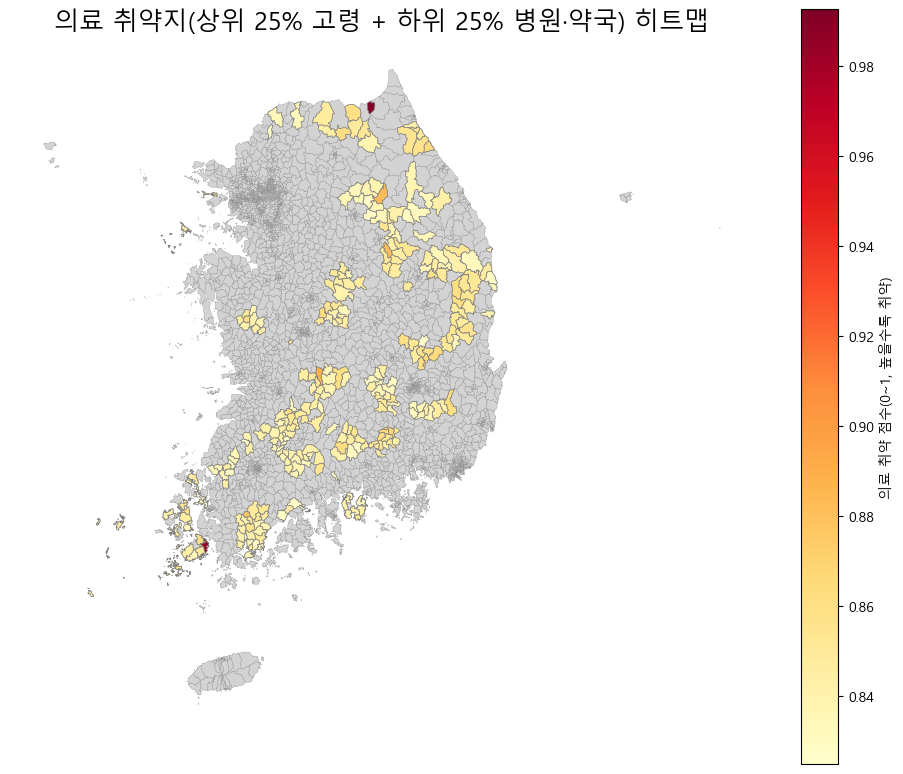

In [94]:
# maybe_vulnerable 조건 적용
infra_df['maybe_vulnerable'] = (
    (infra_df['aged_ratio'] > infra_df['aged_ratio'].quantile(0.75)) &
    (infra_df['hospital_per_1000_aged'] < infra_df['hospital_per_1000_aged'].quantile(0.25)) &
    (infra_df['pharmacy_per_1000_aged'] < infra_df['pharmacy_per_1000_aged'].quantile(0.25))
)

# maybe_vulnerable이 True인 데이터만 집계
vulnerable_df = infra_df[infra_df['maybe_vulnerable']]
score_by_region = vulnerable_df.groupby(['Sido', 'Sigungu', '읍면동명'])['vulnerability_score'].mean().reset_index()

# GeoJSON 불러오기 및 행정구역명 분리
gdf = gpd.read_file("C:/Users/QQQ/Downloads/HangJeongDong_ver20250401.geojson")
gdf[['시도', '시군구', '읍면동']] = gdf['adm_nm'].str.split(expand=True)

# 병합 (maybe_vulnerable True인 지역만)
merged = gdf.merge(
    score_by_region,
    left_on=['시도', '시군구', '읍면동'],
    right_on=['Sido', 'Sigungu', '읍면동명'],
    how='left'
)

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(12,14))
gdf.plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=0.2)  # 전체 배경
merged[merged['vulnerability_score'].notna()].plot(
    column='vulnerability_score',
    cmap='YlOrRd',
    legend=True,
    ax=ax,
    linewidth=0.5,
    edgecolor='gray',
    legend_kwds={'label': '의료 취약 점수(0~1, 높을수록 취약)',
                 'shrink': 0.7
                 }
)
ax.set_title('의료 취약지(상위 25% 고령 + 하위 25% 병원·약국) 히트맵', fontsize=18)
ax.axis('off')
plt.show()

In [ ]:
# maybe_vulnerable이 True인 것만 vulnerability_score 기준 내림차순 정렬
sorted_vulnerable = infra_df[infra_df['maybe_vulnerable']].sort_values('vulnerability_score', ascending=False)

print(sorted_vulnerable[['Sido', 'Sigungu', '읍면동명', 'vulnerability_score']].head(10))

          Sido Sigungu 읍면동명  vulnerability_score
16752  강원특별자치도     양구군  해안면             0.992677
5420      충청북도     단양군  매포읍             0.988066
18075  전북특별자치도     무주군  부남면             0.987035
10125     전라남도     진도군  고군면             0.983920
4774      충청북도     보은군  내북면             0.905415
14432     경상남도     의령군  부림면             0.903601
14449     경상남도     의령군  궁류면             0.903060
9145      전라남도     장흥군  부산면             0.896612
9119      전라남도     장흥군  장평면             0.895168
14448     경상남도     의령군  봉수면             0.893662
